In [1]:
#pip install spotipy --upgrade              # Uncomment this and run it if you haven't installed spotipy before


In [2]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import re, glob
import os, sys
from scipy import stats

import spotipy                          # Set up a config file with ckey and skey. These are available if you go
from spotipy.oauth2 import SpotifyClientCredentials      # to https://developer.spotify.com/, click on Dashboard 
                                        # from the horizontal black menu, login with your normal user info. Click 
# Import Keys                           # on "create an app" if you haven't yet, it doesn't matter what you call it.
from config import clientID, clientSEC           # Then click into
                                        # your project and you should see Client ID and Client Secret. Those are your 
                                        # ckey and skey. 

In [3]:
# Setting up Spotify API info

client_credentials_manager = SpotifyClientCredentials(client_id=clientID, client_secret=clientSEC)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)



TIP: This next section assumes that you have already downloaded the csv files with the Top200 charts for the country you are working on:

1. Create a subfolder in the folder this notebook is located in called "input_files". Add the owid-covid-data.csv file there, you'll need that later. Then make another subfolder inside input_files called "spotify_top200_charts". Save the csv files you download there. 
2. Go to https://spotifycharts.com
2. Choose the country you want to work on. 
3. Download Weekly Top200 charts for 2019 and 2020, 1 chart per month. We agreed as a group to download the chart from last week of each month, to keep things consistent. Save them in the "spotify_top200_charts" folder you set up. 

In [4]:
# Create dataframe from weekly chart data


path = r"input_files/spotify_top200_charts/*.csv"                # The path requires "".csv" at end of file name. 
                                                                 # This is to prevent the program from blowing up
                                                                 # when it hits some kind of hidden file. 

country_tracks_df = pd.read_csv(glob.glob(path)[0], header=1)    # Sets up **main dataframe** with data from **FIRST** file
string = str(glob.glob(path)[0])                                 # in the folder.
year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)   # This line extracts the year and month from the 
                                                                 # **file name**
country_tracks_df[['Year']] = year_month[0]
country_tracks_df[['Month']] = year_month[1]
country_tracks_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1]) 
Tot_Streams1 = country_tracks_df['Streams'].sum()                # Find out total streams in FIRST file in folder.
country_tracks_df[['Stream %']] = country_tracks_df['Streams'] / Tot_Streams1    # New column with % of streams

for file in glob.glob(path)[1:]:                                 # Now that you have the dataframe set up from the 
        temp_df = pd.read_csv(file, header=1)                    # first file in the folder, this iterates through 
        string = str(file)                                       # remaining files
        year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)
        #print (year_month)
        Tot_Streams2 = temp_df['Streams'].sum()
        temp_df[['Year']] = year_month[0]
        temp_df[['Month']] = year_month[1]
        temp_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1])
        temp_df[['Stream %']] = temp_df['Streams'] / Tot_Streams2
        country_tracks_df = pd.concat([country_tracks_df,        # Adds temperary datafame to end of main dataframe
                                       temp_df])                 # as new rows.  ¿¿¿???? 
        

                                                 
country_tracks_df = country_tracks_df.sort_values(['Year','Month'])  # Sort the new dataframe by year and month




                                                                 # You should get 4,800 rows (24 months x 200 
                                                                 # tracks per month)
country_tracks_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %
0,1,Calma - Remix,Pedro Capó,4623479,https://open.spotify.com/track/5iwz1NiezX7WWjn...,2019,01,2019-01,0.028262
1,2,Adan y Eva,Paulo Londra,3567452,https://open.spotify.com/track/6FyRXC8tJUh863J...,2019,01,2019-01,0.021807
2,3,Secreto,Anuel AA,3445374,https://open.spotify.com/track/5W83ErFkO3aKAIS...,2019,01,2019-01,0.021061
3,4,Desconocidos,Mau y Ricky,3125808,https://open.spotify.com/track/0s5DNDV6LAKn2u2...,2019,01,2019-01,0.019107
4,5,MIA (feat. Drake),Bad Bunny,2655672,https://open.spotify.com/track/116H0KvKr2Zl4RP...,2019,01,2019-01,0.016233
...,...,...,...,...,...,...,...,...,...
195,196,Las Mil Y Una Noches,Flans,576850,https://open.spotify.com/track/0b53GyMOfBCt5L6...,2020,12,2020-12,0.002595
196,197,Tutu,Camilo,576529,https://open.spotify.com/track/1Ol5LmdNDNpFu1o...,2020,12,2020-12,0.002593
197,198,Decepciones,Alejandro Fernández,574834,https://open.spotify.com/track/2LTYkSso5VAfdqz...,2020,12,2020-12,0.002586
198,199,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,574459,https://open.spotify.com/track/0RiRZpuVRbi7oqR...,2020,12,2020-12,0.002584


In [5]:
# Get Track IDs
track_names = country_tracks_df['Track Name'].to_list()           # Set up list of tracks to iterate through         
track_ids = []                                                    # Empty list to record track IDs into

for track in track_names:                                         # Heads up: with 4800 tracks to process, this takes
    song_results = sp.search(q=track, type='track', limit=1)      # awhile 
    try:
        track_ids.append(song_results['tracks']['items'][0]['id']) # Prevents program from blowing up - few tracks
        print (f"{track} song ID : {song_results['tracks']['items'][0]['id']}")   # Just to let you know it's working
    except IndexError:                                             # lack track ids
        track_ids.append(np.nan)                                   # nan if nothing

Calma - Remix song ID : 5iwz1NiezX7WWjnCgY5TH4
Adan y Eva song ID : 6FyRXC8tJUh863JCkyWqtk
Secreto song ID : 5W83ErFkO3aKAIS1WMi6u0
Desconocidos song ID : 56f5qnyAlZdlz8wrUDA50h
MIA (feat. Drake) song ID : 116H0KvKr2Zl4RPuVBruDO
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Te Vi song ID : 059bcIhyc2SBwm6sw2AZzd
Ella Quiere Beber - Remix song ID : 3f5lA8nnc4YYF1qf78WpHw
Taki Taki (with Selena Gomez, Ozuna & Cardi B) song ID : 4w8niZpiMy6qz1mntFA5uM
Baby Girl (feat. Lalo Ebratt) song ID : 6o8ogTrSX8H0F66Pdz3Tsc
Baila Baila Baila song ID : 7mWFF4gPADjTQjC97CgFVt
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Sola song ID : 0Jr4zQh5i3vrKFEcXrhhxl
Un Año song ID : 7onmX3EZ9Vq7v68aObV2sa
Amigos Con Derechos song ID : 4yVO0wOhXsZC1RuPgHP524
No Te Contaron Mal song ID : 7hbk4BaF66O09R1gq0bKwj
Ni Gucci Ni Prada song ID : 32lexhcz93AinKK0qLTZaZ
Imposible song ID : 3ao3OVxHlb3C08vAaApUlm
A Través Del Vaso song ID : 0oCSitNlzsQfuIapF9tXRQ
Vaina Loca song ID : 48zFZh27QU

Vasos Vacíos - Remasterizado 2008 song ID : 198qSChSMQFuSimdeeY9gK
God's Plan song ID : 6DCZcSspjsKoFjzjrWoCdn
Traicionera song ID : 0OjlSAYEn9ZEvyRsbV2Ubg
Esperándote song ID : 1nfyE13arjOuO54HH0zmqj
Sería Más Fácil song ID : 0CWaxJ91qi0NVrXkUIBxs7
Mi Sorpresa Fuiste Tú song ID : 7M8JZ3rGNZgDCrcpDB2k37
Me Muero song ID : 4dpTz2Tgczw9lDdBAT0fvT
Corazón (feat. Nego do Borel) song ID : 5cepAtqnEQ6yVG6088zMMu
Tengo Que Colgar song ID : 2yGNkkwU2iT0doFxkxhcXH
Me Hace Tanto Bien song ID : 5bN4nYjSMkA0ZhGHxDBuip
I'm Not The Only One song ID : 7795WJLVKJoAyVoOtCWqXN
Sweet Child O' Mine song ID : 7snQQk1zcKl8gZ92AnueZW
Amigos No por Favor (Primera Fila) - En Vivo song ID : 7byP4Tul1sLESm3OsC6pO0
Síguelo Bailando song ID : 5Y9fnynLlIvqtM710MHzfz
Llegaste Tú song ID : 7gM4yg1yEERGq1V8VHYypw
no tears left to cry song ID : 2qT1uLXPVPzGgFOx4jtEuo
Downtown song ID : 4kY7rYtE4OQkJNq22OIYRI
Gente De Accionar song ID : 3ZpajXo0KgjHw5WSMMIDfy
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
SAD! song ID : 3e

MALA song ID : 70uX4beGHc1nQikXveOknp
Besos En Guerra song ID : 5RPYHXSqcWaaiCbUbyfNAO
Booty song ID : 6OCqV7mvGa48K7UkgkP0p1
Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
Se Preparó song ID : 1m69ELEgE6k5ZWsap40ozt
Hipócrita song ID : 4CbANooTL2aTHzJZqQ0Uvk
Luz De Dia song ID : 6TqXieeBcZZHyaO14hQpKx
Ta To Gucci (Remix) song ID : 7kuRvjpeUcn6qNV9IBXC2C
Culpables song ID : 3oL3s33HbtOQi0bWP5lYvN
A Lo Lejos Me Veran song ID : 3VHtIuKm8MvOTo81Usu2f5
La Planta song ID : 2GggG2lQVYuus2aeAybe8M
Si Te Vienen a Contar song ID : 1qNUhmx3rGjiMRThz7Eruv
Locos song ID : 3GSMdtJphymHEsR8K9jT5Q
Desde Cero (feat. Santa Fe Klan) song ID : 56dwc4Rm7t00qpsQzefuVi
Calidad Y Cantidad song ID : 0nfp44XFmPrLDMMmYfNIP3
Déjalo song ID : 1gDN23O2aqeWX5NqjSnAbV
Every Breath You Take - Remastered 2003 song ID : 0wF2zKJmgzjPTfircPJ2jg
Culpable Tu song ID : 4Ql7BmZ09FwOENYLVK5Lcd
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
A Solas - Remix song ID : 1fXEkSum1vbTa3w0yvYzYW
Epa Wei song ID : 2QmsKag0YaqhAbpR9Nwmpn
Contigo S

Don't Stop Me Now - Remastered 2011 song ID : 7hQJA50XrCWABAu5v6QZ4i
Otra vez (feat. J Balvin) song ID : 3QwBODjSEzelZyVjxPOHdq
Asesina - Remix song ID : 59PYgzOiOjGDzjDT5N5oOX
Nena Maldición (feat. Lenny Tavárez) song ID : 77dMSg2VHi2wwXjXNrmcrZ
Brillas song ID : 6VuUMo1TusnqBxLTnr3hOI
Te Amo song ID : 2Y1qcW4b9aVRnX1fHaVvxY
Prometiste song ID : 2UypFzxfaYgMUnQX2k4qtj
La Dosis Perfecta song ID : 5bymCzswBkt0deeD1hlTIq
Seremos song ID : 0B5nnPv1ebuo0VFXCMfUij
Nadie song ID : 3YdshshEFnDVPZHovHozmE
Ráptame song ID : 7KvrfnCkHb2qBDyVOqJ2bt
Lamento Boliviano song ID : 6Pur3hWy6Nzc27ilmsp5HA
Culpable O No - Miénteme Como Siempre song ID : 7BwxbmYFy0l3ROHDjV2c14
Tu Postura song ID : 4RNzKQEzmlvVHca4t6Txkj
Eres song ID : 6I86RF3odBlcuZA9Vfjzeq
Por Perro song ID : 4ZpDG0tZQSirMsEIi4CAAv
No Me Acuerdo song ID : 1G586ld1gbaECg4Bc6w40O
A Mí song ID : 6ScJMrlpiLfZUGtWp4QIVt
Do I Wanna Know? song ID : 5FVd6KXrgO9B3JPmC8OPst
Under Pressure - Remastered 2011 song ID : 11IzgLRXV7Cgek3tEgGgjw
Si Se Da

Déjala Que Vuelva (feat. Manuel Turizo) song ID : 1j6xOGusnyXq3l6IryKF3G
PPP song ID : 14eTSBjCDBNyXv8taIyzKd
Ya No Tiene Novio song ID : 1riyn0cmi87k1YsBn4Lfwk
Déjate Querer song ID : 3h8oIZTniP8KIrLhELvXin
Adiós Amor song ID : 63bmZnBN1CiJ9sA4qTEe8y
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Probablemente song ID : 4prmUBle7TtAeeUgCnsc3Z
Baby song ID : 6epn3r7S14KUqlReYr77hA
Sin Pijama song ID : 2ijef6ni2amuunRoKTlgww
Another One Bites The Dust - Remastered 2011 song ID : 57JVGBtBLCfHw2muk5416J
Punto G song ID : 66AmCCC2MuswYD3sOLuuQe
Puntos Suspensivos song ID : 04cd1MHVq1D8v1nuTZoCdv
BEBE song ID : 7D7EH7MGyNHWSkqrszerI1
R.I.P. (feat. Rita Ora & Anitta) song ID : 6JqpFboOH2bq9pzaYbkKBn
Dile la Verdad song ID : 6qP73DRFGojLuIk1siIhNE
Aerolínea Carrillo song ID : 0xYTyyfV767E2Vn3hz56kL
Si Se Da song ID : 6K5BsR04ijf3FHNzjbaagD
Promises (with Sam Smith) song ID : 5N5k9nd479b1xpDZ4usjrg
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
La Escuela No Me Gustó song ID : 4qArK

No Lo Trates song ID : 4gqMVEJSaL5nNeKj5WmVoT
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
MIA (feat. Drake) song ID : 116H0KvKr2Zl4RPuVBruDO
Que Le De song ID : 08aYFNUTIOMGq93e2VSArQ
Solo Pienso En Ti (feat. De La Ghetto & Justin Quiles) song ID : 3H9GDhVVTlmFQSmpt51qiP
Fuentes de Ortiz song ID : 0akyEssGRVHstqCSWXusJL
No Te Contaron Mal song ID : 7hbk4BaF66O09R1gq0bKwj
Me Rehúso song ID : 6De0lHrwBfPfrhorm9q1Xl
Punto G song ID : 66AmCCC2MuswYD3sOLuuQe
Mala Fama song ID : 4lInievSymqKTddxwtXYfl
Créeme song ID : 0mqayP1Moez8gMZ06oq7rD
Mañana Es Too Late song ID : 7ckO8bTkYT5YzwzwnZ6v5a
Taki Taki (with Selena Gomez, Ozuna & Cardi B) song ID : 4w8niZpiMy6qz1mntFA5uM
Homerun (Intro) song ID : 7kh95COsNZjnTmc6aF76n7
Ni Gucci Ni Prada song ID : 32lexhcz93AinKK0qLTZaZ
Baby Girl (feat. Lalo Ebratt) song ID : 6o8ogTrSX8H0F66Pdz3Tsc
Mejor No Nos Vemos song ID : 6NT4RZ6CF6qFJqslGdqaRM
Amigos Con Derechos song ID : 4yVO0wOhXsZC1RuPgHP524
Baila Conmigo song ID : 079Ey5uxL04AKPQgVQwx5h
Ahora Te Puedes

Escápate Conmigo (feat. Ozuna) song ID : 1KSqYYJFyfTecXFk9M0prc
El Amor de Mi Vida song ID : 2xxq5LXFBFyawPChsOOWVu
Háblame De Ti song ID : 1O18MtSAMUk7JfAVB8gGzs
Get You The Moon (feat. Snøw) song ID : 4ZLzoOkj0MPWrTLvooIuaa
Otro Trago song ID : 4bTZeO72FwMa6wKOiqoynL
Callaita song ID : 2TH65lNHgvLxCKXM3apjxI
11 PM song ID : 7KbF6AdprOXEEHlsq11Z6d
Soltera - Remix song ID : 1c0hsvHLELX6y8qymnpLKL
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Tal Vez song ID : 7Aiq4g8tSExAM2qUNkiHbZ
Con Altura song ID : 2qG5sZ7Si6sdK74qLxedYM
HP song ID : 1LIqNVhaIgxXUt2eVoIQJ3
Con Calma song ID : 5w9c2J52mkdntKOmRLeM2m
Baila Conmigo (feat. Kelly Ruiz) song ID : 4Clmg1g8n2yBYG13Z1oSdG
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Te Vi song ID : 059bcIhyc2SBwm6sw2AZzd
Pa Mí - Remix song ID : 7g8YaUQABMal0zWe7a2ijz
Te Robaré song ID : 4PJ3umtW1aWdfh5EITHc6T
Verte Ir song ID : 4lzxJ4jCuFDXXGkE1LmpKR
No Me Conoce - Remix song ID : 4R8BJggjosTswLxtkw8V7P
Old Town Road (feat. Billy Ray Cyrus) - Remix song ID : 6zpiwi

A Mí song ID : 6ScJMrlpiLfZUGtWp4QIVt
Sigo Chambeando song ID : 4PR0r2us3a64lTew6TVlF2
Bubalu song ID : 7dNwJbsT0sg1le5kVugGJb
Guayo song ID : 4MR1AZhe1p0zTuH2HGhX9L
Don't Stop Me Now - Remastered 2011 song ID : 7hQJA50XrCWABAu5v6QZ4i
The Scientist song ID : 75JFxkI2RXiU7L9VXzMkle
thank u, next song ID : 3e9HZxeyfWwjeyPAMmWSSQ
Traicionera song ID : 0OjlSAYEn9ZEvyRsbV2Ubg
Luz De Dia song ID : 6TqXieeBcZZHyaO14hQpKx
Natural song ID : 2FY7b99s15jUprqC0M5NCT
Soltera song ID : 1c0hsvHLELX6y8qymnpLKL
Bella song ID : 2gMo97mAY1eW2iJ8fF6sDw
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Besos En Guerra song ID : 5RPYHXSqcWaaiCbUbyfNAO
I'm Not The Only One song ID : 7795WJLVKJoAyVoOtCWqXN
Dembow song ID : 0j1VxrPkMyFGvz0jZzxUoZ
Amor A Primera Vista song ID : 5Myb8S90Wg0yLec5kmrIGJ
Solita song ID : 7rwX0O3RlxqqIjQM8evm5E
Mala Mía song ID : 62o8KoI44JfN7aYxgTnPvh
Afuera song ID : 3pJfnBjO3kjudEchcPEDxS
Si Te Vienen a Contar song ID : 1qNUhmx3rGjiMRThz7Eruv
La Planta song ID : 2GggG2lQVYuus2aeAybe8M
Fíj

Culpable O No - Miénteme Como Siempre song ID : 7BwxbmYFy0l3ROHDjV2c14
Eres song ID : 6I86RF3odBlcuZA9Vfjzeq
UN PESO song ID : 7hynhxDoDpgMIV12JuVtNa
No Es Justo song ID : 4ENLcCIsIe3WQBklJSBQxK
Te Boté - Remix song ID : 3V8UKqhEK5zBkBb6d6ub8i
La flaca song ID : 0ll9JAIrM3NVBOMl45sxSX
¿CÓMO TE VA, QUERIDA? song ID : 2p89F5HPntIfuJ1SnuPoeK
El Sol No Regresa song ID : 0c8f8b76ThPP2MInXEZyTY
Mentiroso song ID : 5iXCrcLT5iirF2UTmaa284
Una Vida Para Recordar song ID : 7pxL0DzPpCjjcdfQccvnus
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Nena Maldición (feat. Lenny Tavárez) song ID : 77dMSg2VHi2wwXjXNrmcrZ
En Donde Esta Tu Amor song ID : 6jweSpMwhhNpfILeZ3kLso
Loco (Tu Forma de Ser) [Ft. Rubén Albarrán] - MTV Unplugged song ID : 0639sfoRA7sW4fGS1EzcQu
Nothing On You (feat. Paulo Londra & Dave) song ID : 2qRN7PWiHRLprw4FpDeI9N
Locos song ID : 3GSMdtJphymHEsR8K9jT5Q
Baila Baila Baila song ID : 7mWFF4gPADjTQjC97CgFVt
Cristina song ID : 1Kjer1JoWuJGNwGV6Pbgv1
Puntos Suspensivos song ID : 04cd1MHVq1D8v

Me Dediqué a Perderte song ID : 4NUt1fcnO9aQAELBgXq3Kr
La Incondicional song ID : 6F9yAYUaNbUhdlQyt5uZ3b
Contra La Pared song ID : 37eGbhE1xVFSvcKkqGb6i1
Si Se Da song ID : 6K5BsR04ijf3FHNzjbaagD
Miami Vibe song ID : 6ZUBqOrjrdmkP4eLQLBeaq
Sola song ID : 0Jr4zQh5i3vrKFEcXrhhxl
Cuando Te Besé song ID : 2XXMDz7SPZ4mSFN1PXfHUy
Bohemian Rhapsody - Remastered 2011 song ID : 7tFiyTwD0nx5a1eklYtX2J
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Baila Baila Baila - Remix song ID : 7mWFF4gPADjTQjC97CgFVt
Créeme song ID : 0mqayP1Moez8gMZ06oq7rD
El Amor de Mi Vida song ID : 2xxq5LXFBFyawPChsOOWVu
Taki Taki (feat. Selena Gomez, Ozuna & Cardi B) song ID : 0KoiMHhqKLoL4xM54rcWYY
Esclavo de Tus Besos song ID : 3g4UyIcQwutiG0TfW32GnX
Te Quemaste song ID : 4fj7e6Tc48Bmomwyz2Z2XC
Te Soñé de Nuevo song ID : 4oPnxZzoc8HM5Pva4FDeIp
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Presiento song ID : 0gYnWBpArbOOokGLDDhzyG
Seremos song ID : 0B5nnPv1ebuo0VFXCMfUij
Ya No Tiene Novio song ID :

La Mujer Perfecta song ID : 5XR1WyZ0uOSHRNhP85QxT4
Secreto song ID : 5W83ErFkO3aKAIS1WMi6u0
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
De Los Besos Que Te Di song ID : 1qfoq1qvZT7VwDVeekCJ97
Nunca Es Suficiente song ID : 63USmok1OioBzKuWGW9wAg
DJ No Pare (feat. Zion, Dalex, Lenny Tavárez) - Remix song ID : 1ndyl3wJCFs872XZ3ztPk6
Un Año song ID : 7onmX3EZ9Vq7v68aObV2sa
Ella Quiere Beber - Remix song ID : 3f5lA8nnc4YYF1qf78WpHw
Cuaderno song ID : 7anSoGdgtmJTAPZBzcPhO6
Atrévete song ID : 1q8NdCAQ9QUjpYiqzdd3mv
Don’t Call Me Angel (Charlie’s Angels) (with Miley Cyrus & Lana Del Rey) song ID : 6zegtH6XXd2PDPLvy1Y0n2
Si Se Da - Remix song ID : 6K5BsR04ijf3FHNzjbaagD
No Lo Trates song ID : 4gqMVEJSaL5nNeKj5WmVoT
La Escuela No Me Gustó song ID : 4qArKIA7dnmdushoBlkV94
Prometiste song ID : 2UypFzxfaYgMUnQX2k4qtj
Rebota - Remix song ID : 3dWpRjCmaHbroNahuSeX11
En Peligro de Extinción song ID : 45sVRPegWSGpIcsrDoaaCY
Me Rehúso song ID : 6De0lHrwBfPfrhorm9q1Xl
Brillas song

No Se Me Quita (feat. Ricky Martin) song ID : 1GBLO0NFODuL31A5fgw0uR
Qué Pena song ID : 5099x34vBakWpGkHourFxP
Si Te Vas song ID : 6Y4PDQv4XjYjHLeLmvyOt0
Otro Trago song ID : 4bTZeO72FwMa6wKOiqoynL
Tra Tra Tra Remix - Remix song ID : 4YqCBC4FwzGXuhixt5cgmm
Loco Contigo (feat. J. Balvin & Tyga) song ID : 6osaMSJh9NguagEDQcZaKx
Soy El Diablo - Remix song ID : 7pNAvsuTCFaXzSSUmfBPxz
Look At Her Now song ID : 6ABeuUrilSljBZFfBC9fQL
Me La Avente song ID : 2QwMXe5zbqymDZGYsMDVqZ
Lalala song ID : 51Fjme0JiitpyXKuyQiCDo
Otro Trago - Remix song ID : 4bTZeO72FwMa6wKOiqoynL
Tal Vez song ID : 7Aiq4g8tSExAM2qUNkiHbZ
Fuentes de Ortiz song ID : 0akyEssGRVHstqCSWXusJL
Chicharrón song ID : 5UVa8Qqb9L1dVxl3jKQ5J1
Mala Fama song ID : 4lInievSymqKTddxwtXYfl
Contando Lunares (feat. Cruz Cafuné) song ID : 6uW0PIRcyZLvkoonm763xD
Desconocidos song ID : 56f5qnyAlZdlz8wrUDA50h
Te Vi song ID : 059bcIhyc2SBwm6sw2AZzd
DJ No Pare (feat. Zion, Dalex, Lenny Tavárez) - Remix song ID : 1ndyl3wJCFs872XZ3ztPk6
How Do You

Fíjate Que Si song ID : 3YwEMdP2zkOiIq074Vlvqc
Nicki Nicole: Bzrp Music Sessions, Vol. 13 song ID : 2S93hylQBYLndMnaJuso8S
Besos En Guerra song ID : 5RPYHXSqcWaaiCbUbyfNAO
Leve song ID : 6xZ4Q2k2ompmDppyeESIY8
Follow God song ID : 2QpGZOhTCHHiKmpSO9FW4h
Buenos Genes song ID : 76NtMPMpA6fuUH4euMYZoD
Sin Pijama song ID : 2ijef6ni2amuunRoKTlgww
Aerolínea Carrillo song ID : 0xYTyyfV767E2Vn3hz56kL
No Lo Trates song ID : 4gqMVEJSaL5nNeKj5WmVoT
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
El Amor No Fue Pa´ Mí - En Vivo song ID : 3dkEwOKhFselY2m22Nj2vi
Rosas song ID : 06p2Ij0lXD45LODQDCov0u
No Es Justo song ID : 4ENLcCIsIe3WQBklJSBQxK
Vete song ID : 5DxXgozhkPLgrbKFY91w0c
Tusa song ID : 7k4t7uLgtOxPwTpFmtJNTY
RITMO (Bad Boys For Life) song ID : 6cy3ki60hLwimwIje7tALf
LA CANCIÓN song ID : 0fea68AdmYNygeTGI4RC18
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Pa' Olvidarme De Ella song ID : 1cVlW9WQiGlFdWUXFdFZGh
Callaita song ID : 2TH65lNHgvLxCKXM3apjxI
No Me Conoce - Remix so

Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Culpable O No - Miénteme Como Siempre song ID : 7BwxbmYFy0l3ROHDjV2c14
Rebota song ID : 2YRvdf9cdS88y1wB1WhKoE
El Güero - En vivo song ID : 7a6gK5GwlIvGTU4ayZhskd
Te quiero song ID : 1Z4IqxukC6Yuer0nK7rC2R
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
Hola - Remix song ID : 5stPVcRqb4qixbafP9e8lt
Another One Bites The Dust - Remastered 2011 song ID : 57JVGBtBLCfHw2muk5416J
Rompelo song ID : 6k2evQXcf7n9Lbc7V5XkOX
Promises (with Sam Smith) song ID : 5N5k9nd479b1xpDZ4usjrg
In My Mind song ID : 0E9ZjEAyAwOXZ7wJC0PD33
Runaway song ID : 0TCmhnbMpw5zwPsTvlXTJi
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Every Breath You Take song ID : 1JSTJqkT5qHq8MDJnJbRE1
Seguimos Laborando song ID : 6H9H6BYpuWycXP9HEx3vdJ
La flaca song ID : 0ll9JAIrM3NVBOMl45sxSX
Acurrucar song ID : 0vTmuKsIgqtez9Ups70mQU
Locos song ID : 3GSMdtJphymHEsR8K9jT5Q
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Entre Beso Y Beso song ID : 6HhdH

Brillas song ID : 6VuUMo1TusnqBxLTnr3hOI
Seremos song ID : 0B5nnPv1ebuo0VFXCMfUij
Lamento Boliviano song ID : 6Pur3hWy6Nzc27ilmsp5HA
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
La Boca song ID : 0UQwlF2pRkr1lMN6kNNUj3
Perreo en La Luna song ID : 0RDgqtvOHLwcI6yz9bjsZV
Tu Postura song ID : 4RNzKQEzmlvVHca4t6Txkj
Procura song ID : 2q9udNV9NK0BL3q9p6TLxf
En Donde Esta Tu Amor song ID : 6jweSpMwhhNpfILeZ3kLso
Mi Enemigo El Amor song ID : 3V5mrjHNr7VFhcUJ5oh45V
Heartless song ID : 4EWCNWgDS8707fNSZ1oaA5
UN PESO song ID : 7hynhxDoDpgMIV12JuVtNa
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
ROXANNE song ID : 696DnlkuDOXcMAnKlTgXXK
Te Robaré song ID : 4PJ3umtW1aWdfh5EITHc6T
Vete Ya song ID : 3gqgSM82j6NMAj4Jllr06T
El Amor de Mi Vida song ID : 2xxq5LXFBFyawPChsOOWVu
Hasta Que Salga el Sol song ID : 0dDboLfmRNsTBscy4j3Rnl
Bellaquita song ID : 1tpbAGsGpZee5jDHMcLrUJ
Aleluya song ID : 23CsjGOYDQiJpX44BSn9TM
Sigo Chambeando song ID : 4PR0r2us3a64lTew6TVlF2
Cómo Te Voy A Olvidar song ID : 51dNexiESqcJLsGLr

Loco Contigo (with J. Balvin & Ozuna feat. Nicky Jam, Natti Natasha, Darell & Sech) - REMIX song ID : 5QXQy0f2q8wJNpPwJtjifx
How Do You Sleep? song ID : 6b2RcmUt1g9N9mQ3CbjX2Y
La Mujer Perfecta song ID : 5XR1WyZ0uOSHRNhP85QxT4
Adore You song ID : 3jjujdWJ72nww5eGnfs2E7
Tu Sicaria song ID : 6fatMybX8VmHUpaxVcXzrz
Fantasía song ID : 6mAN61JH0dzyZpWslS11jy
Adan y Eva song ID : 6FyRXC8tJUh863JCkyWqtk
Detente song ID : 0x1k6gSTSxaLxe0F2IThaX
En Peligro de Extinción song ID : 45sVRPegWSGpIcsrDoaaCY
Simplemente Gracias song ID : 3K6noLeoPTQJ5jUErC8jT5
Bonita song ID : 0atfY1ew83Ql9nNnJiD2t5
Tequila song ID : 42fw0rxRO2xbesF6mJfd4Y
Me Dediqué a Perderte song ID : 4NUt1fcnO9aQAELBgXq3Kr
Bellaquita song ID : 1tpbAGsGpZee5jDHMcLrUJ
Si Estuviésemos Juntos song ID : 35wvL50xvKpCHEJPxLOLPI
UN PESO song ID : 7hynhxDoDpgMIV12JuVtNa
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Brillas song ID : 6VuUMo1TusnqBxLTnr3hOI
Baila Conmigo (feat. Kelly Ruiz) song ID : 4Clmg1g8n2yBYG13Z1oSdG
Lalala song ID : 51Fjme0

Perreo en La Luna song ID : 0RDgqtvOHLwcI6yz9bjsZV
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Physical song ID : 3AzjcOeAmA57TIOr9zF1ZW
DJ No Pare (feat. Zion, Dalex, Lenny Tavárez) - Remix song ID : 1ndyl3wJCFs872XZ3ztPk6
Imposible Amor song ID : 5zRusJsWuFeLu2sICWvVDF
Perdiendo la Cabeza song ID : 2GTCK8zYHwkcu0i0jtKjFz
Otro Trago song ID : 4bTZeO72FwMa6wKOiqoynL
Tal Vez song ID : 7Aiq4g8tSExAM2qUNkiHbZ
Indeciso song ID : 59s0s39NFWScuHDbHytI14
Medusa song ID : 3qM0vBxIe4VUbK0Z0smuVP
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
Te Olvidé song ID : 1YoSNhqlNArolB7VQC7aaS
Detente song ID : 0x1k6gSTSxaLxe0F2IThaX
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
ROXANNE song ID : 696DnlkuDOXcMAnKlTgXXK
Si Estuviésemos Juntos song ID : 35wvL50xvKpCHEJPxLOLPI
Cada Vez Te Extraño Más song ID : 70w1mwTod6NgCNV6e7ZlIQ
everything i wanted song ID : 3ZCTVFBt2Brf31RLEnCkWJ
Si Me Dices Que Sí song ID : 56Ta1O7Jxxpjnc6cWdDKUo
El Amor No Fue Pa´ Mí - En Vivo song ID : 3dkEwOKhFselY2m22Nj2vi
Con Calma s

Pero Ya No song ID : 75pQqzwgCjUOSSy5CpmAjy
Hola - Remix song ID : 5stPVcRqb4qixbafP9e8lt
Diosa song ID : 3JHpk0DOTOzyh0777JFAky
LA CANCIÓN song ID : 0fea68AdmYNygeTGI4RC18
Negro song ID : 0eB1AsERUb23HWSqmH1NBS
Callaita song ID : 2TH65lNHgvLxCKXM3apjxI
No Me Conoce - Remix song ID : 4R8BJggjosTswLxtkw8V7P
Sodio song ID : 7jYZU1CIruZU3puB5tiYiW
Say So song ID : 3Dv1eDb0MEgF93GpLXlucZ
Gris song ID : 1syf62zw48zu4FrPwMtDHk
Fantasias song ID : 6mAN61JH0dzyZpWslS11jy
After Hours song ID : 2p8IUWQDrpjuFltbdgLOag
In Your Eyes song ID : 7szuecWAPwGoV1e5vGu8tl
Verde song ID : 5UoFolYVqme3NABM96m0cD
Bichiyal song ID : 4j4w4CXm6BSr0s25wAWrrX
RITMO (Bad Boys For Life) song ID : 6cy3ki60hLwimwIje7tALf
Oye Pablo song ID : 1Hu3v5cB7TrKdfZ1taqS9E
China song ID : 2ksOAxtIxY8yElEWw8RhgK
Yo Ya No Vuelvo Contigo - En Vivo song ID : 1s59X35jDULAyOGmBuTAnd
Soliá song ID : 7sOfmPd18RWp3FoCzpa7Kw
Muévelo song ID : 4VgYtXCVJ7IbWAZ5ryfvEQ
De Los Besos Que Te Di song ID : 1qfoq1qvZT7VwDVeekCJ97
Keii song ID : 5

Devuélveme a mi chica song ID : 1Wrzhfa5bNlqvsnCztz190
Until I Bleed Out song ID : 2BcnxwxBuar5wjCaLqm5N3
Aventura song ID : 37zdqI4r1gswIzczSBkRon
Aleman: Bzrp Music Sessions, Vol. 15 song ID : 7xRWmHZ2wt3zDgM5mAL0JU
Secreto song ID : 5W83ErFkO3aKAIS1WMi6u0
Safaera song ID : 2DEZmgHKAvm41k4J3R2E9Y
Favorito song ID : 0Snbzbd74RLfL0i4nn1vU5
Yo Perreo Sola song ID : 0SqqAgdovOE24BzxIClpjw
Rojo song ID : 4zrkgzHl26rkCADbWe1PKw
Blinding Lights song ID : 0VjIjW4GlUZAMYd2vXMi3b
Si Veo a Tu Mamá song ID : 41wtwzCZkXwpnakmwJ239F
Tusa song ID : 7k4t7uLgtOxPwTpFmtJNTY
Jangueo song ID : 1bRpSCFv6P2OUhciByeRYR
Tattoo song ID : 1Srt81FTalOhRw7t7l8Yh8
Morado song ID : 0oMtyJ3w2mCkztYRykM8sg
La Difícil song ID : 6NfrH0ANGmgBXyxgV2PeXt
Ignorantes song ID : 3wYRLYuO1M88d8woWUIxct
Don't Start Now song ID : 6WrI0LAC5M1Rw2MnX2ZvEg
Sigues Con El song ID : 7sQKy5vlPQllr0k9IjYJv3
Amarillo song ID : 6OsbuHK5jQ626AAius3Cqx
Diosa song ID : 3JHpk0DOTOzyh0777JFAky
Se Me Olvidó song ID : 7paFC3FEu1WtPVP4Do6VZN
Bre

Boss Bitch song ID : 78qd8dvwea0Gosb6Fe6j3k
Miami Vibe song ID : 6ZUBqOrjrdmkP4eLQLBeaq
Está Cabrón Ser Yo song ID : 4saHEjXw7O1NXJOzBkUKKG
Follow song ID : 7FdUvDkaE24o3FPIWTvzv2
Burbujas de Cristal song ID : 15yuvKhcoEtV5KwKxqHSwa
Yo x Ti, Tu x Mi song ID : 7BlBVFwvbWvcwNcUarQmjk
Skechers song ID : 2alc8VZAzDgdAsL2QMk3hu
25/8 song ID : 4NqQaovM14WR2hNPMFxgjb
El de La Codeina song ID : 7K2JfvcKhIMwOndE6QBodf
Todos Hablan, Nada Saben song ID : 0SIooo95Kba3UwPBRUOcmd
Otra Noche en Miami song ID : 4vCAzANUWDE24URV6wQ4ra
STARGAZING song ID : 0VF7YLIxSQKyNiFL3X6MmN
Escondidos song ID : 2v2totojcWdvtjy7lAvl9o
Amor del Bueno song ID : 2G74yhtIMW8tJY5I83dS4Z
Level of Concern song ID : 6xZ4Q2k2ompmDppyeESIY8
René song ID : 0fYVliAYKHuPmECRs1pbRf
Seremos song ID : 0B5nnPv1ebuo0VFXCMfUij
La Boca song ID : 0UQwlF2pRkr1lMN6kNNUj3
La Pared 360 song ID : 2w8SKQCnT2YQK1qCqKl2uW
Lose Control song ID : 7CHi4DtfK4heMlQaudCuHK
Devuélveme a mi chica song ID : 1Wrzhfa5bNlqvsnCztz190
Canela song ID : 1yTJg3

Gris song ID : 1syf62zw48zu4FrPwMtDHk
Nunca Es Suficiente song ID : 63USmok1OioBzKuWGW9wAg
El Color de Tus Ojos song ID : 1l77YWrGUp3qX3NS1rz7lq
Rosa song ID : 37BTh5g05cxBIRYMbw8g2T
Bellaquita - Remix song ID : 1Xnn1TPyr5h0hpRAT4B4EA
MAMACITA song ID : 14wf185UxfNbSy8dwt4r4q
BENDICIONES song ID : 2CoMYp2uIKsT09nreEZnZn
La player (Bandolera) song ID : 0VKkyBKCXyR99navhVRqcP
Dancin (feat. Luvli) - Krono Remix song ID : 6WkJ2OK163XXS2oARUC9JM
Otro Trago - Remix song ID : 4bTZeO72FwMa6wKOiqoynL
Culpable O No - Miénteme Como Siempre song ID : 7BwxbmYFy0l3ROHDjV2c14
El Amor No Fue Pa´ Mí - En Vivo song ID : 3dkEwOKhFselY2m22Nj2vi
El de La Codeina song ID : 7K2JfvcKhIMwOndE6QBodf
La Jeepeta - Remix song ID : 1mohfLaTJtB2RplHLQVM70
Lamento Boliviano song ID : 6Pur3hWy6Nzc27ilmsp5HA
Todavia song ID : 3D5uEBD0cAEGZGUo5j9045
Pa Mí - Remix song ID : 7g8YaUQABMal0zWe7a2ijz
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Por Mi No Te Detengas song ID : 3mV5TTtHnXUeOzRkyFKsVl
Belleza De Cantina song ID : 

Nunca Es Suficiente song ID : 63USmok1OioBzKuWGW9wAg
Lost on You song ID : 2LIh4uzqq9cXMPzzmcToHl
En Peligro de Extinción song ID : 45sVRPegWSGpIcsrDoaaCY
PAM song ID : 0eeKDrQxjqNl5bX5VCHDcn
Detente song ID : 0x1k6gSTSxaLxe0F2IThaX
A Mí song ID : 6ScJMrlpiLfZUGtWp4QIVt
BAD CON NICKY song ID : 5bmSver2b3ZXyuyLKtgnFI
Quiéreme Mientras Se Pueda song ID : 34LI7rwi9H8w2S5KTHnv1M
Adiós Amor song ID : 63bmZnBN1CiJ9sA4qTEe8y
Adore You song ID : 3jjujdWJ72nww5eGnfs2E7
Infeliz song ID : 4z6wo6PJG4Fve45OXK6D9m
El Envidioso song ID : 53PoPAD389bBE4ePYuT95g
Te Olvidé song ID : 1YoSNhqlNArolB7VQC7aaS
Calma - Remix song ID : 5iwz1NiezX7WWjnCgY5TH4
El Color de Tus Ojos song ID : 1l77YWrGUp3qX3NS1rz7lq
Bichiyal song ID : 4j4w4CXm6BSr0s25wAWrrX
Culpable O No - Miénteme Como Siempre song ID : 7BwxbmYFy0l3ROHDjV2c14
Sola song ID : 0Jr4zQh5i3vrKFEcXrhhxl
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
La flaca song ID : 0ll9JAIrM3NVBOMl45sxSX
La Mujer Perfecta song ID : 5XR1

Tutu song ID : 1nocRtwyNPVtGcIJqfgdzZ
+Linda song ID : 5cBrOhKDyiJF9bPGUHKkG0
Prometiste song ID : 2UypFzxfaYgMUnQX2k4qtj
Dream Girl - Remix song ID : 099tjv6oy2opbpCOA3nBwX
La Bella y la Bestia song ID : 0G0p7mc4wEaQTsUpzEmkEs
Rain On Me (with Ariana Grande) song ID : 24ySl2hOPGCDcxBxFIqWBu
El Güero (Feat. Marca MP) song ID : 2MeEuwplwbbjZ7hxRI6viw
AYAYAY! song ID : 7iQc2DabEtzp60faOO9EmN
Me Dediqué a Perderte song ID : 4NUt1fcnO9aQAELBgXq3Kr
Mala Fama song ID : 4lInievSymqKTddxwtXYfl
Sodio song ID : 7jYZU1CIruZU3puB5tiYiW
Ride It song ID : 2tnVG71enUj33Ic2nFN6kZ
El Efecto - Remix song ID : 74j34STf8L6uADnTN69ohv
Supalonely song ID : 4nK5YrxbMGZstTLbvj6Gxw
Blanco song ID : 2rc7BkzO8qepMFAxHtOrXc
Arriba song ID : 6MOjqs7ngSnZz3J5GZLAfm
La Incondicional song ID : 6F9yAYUaNbUhdlQyt5uZ3b
Amor Tumbado song ID : 5aJ1M43pinROpwaPnO8KRj
11 PM song ID : 7KbF6AdprOXEEHlsq11Z6d
BYE ME FUI song ID : 0FktnzDqjClqU6iqOZVEs2
Quizas song ID : 5Id5B3dxJZhPcV9GzgYZZe
Ya Me Enteré song ID : 4ggabbjjuHrG

La Santa song ID : 69vlMrzHwATKzupwNcUPyK
Fantasias song ID : 6mAN61JH0dzyZpWslS11jy
Ignorantes song ID : 3wYRLYuO1M88d8woWUIxct
Break My Heart song ID : 017PF4Q3l4DBUiWoXk4OWT
Amor A Primera Vista song ID : 5Myb8S90Wg0yLec5kmrIGJ
CÓMO SE SIENTE - Remix song ID : 2tFwfmceQa1Y6nRPhYbEtC
MAMACITA song ID : 14wf185UxfNbSy8dwt4r4q
Con Tus Besos song ID : 6WYB1odDfMPVMyp1QxFInT
Quiéreme Mientras Se Pueda song ID : 34LI7rwi9H8w2S5KTHnv1M
PORFA song ID : 5CGRlMZ2SIEkgpnrMqoHnY
Tattoo song ID : 1Srt81FTalOhRw7t7l8Yh8
La Difícil song ID : 6NfrH0ANGmgBXyxgV2PeXt
ily (i love you baby) (feat. Emilee) song ID : 62aP9fBQKYKxi7PDXwcUAS
Si Me Dices Que Sí song ID : 56Ta1O7Jxxpjnc6cWdDKUo
AYAYAY! song ID : 7iQc2DabEtzp60faOO9EmN
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
11 PM song ID : 7KbF6AdprOXEEHlsq11Z6d
Vete song ID : 5DxXgozhkPLgrbKFY91w0c
A Mí song ID : 6ScJMrlpiLfZUGtWp4QIVt
Oye Pablo song ID : 1Hu3v5cB7TrKdfZ1taqS9E
Palabra de Hombre song ID : 4UiaP0wBuy9N9voD91OZOg
Callaita song 

Yo Perreo Sola song ID : 0SqqAgdovOE24BzxIClpjw
Parce (feat. Justin Quiles) song ID : 4RJz8NfIe09gpKMiRUWKhJ
Tú song ID : 5KFHrrBMyGj5MhVbZMM3ts
Safaera song ID : 2DEZmgHKAvm41k4J3R2E9Y
Quiéreme Mientras Se Pueda song ID : 34LI7rwi9H8w2S5KTHnv1M
Jangueo song ID : 1bRpSCFv6P2OUhciByeRYR
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Favorito song ID : 0Snbzbd74RLfL0i4nn1vU5
+Linda song ID : 5cBrOhKDyiJF9bPGUHKkG0
Amor Tóxico song ID : 5LPlvbxA6bJQHvUW12Mr22
Tusa song ID : 7k4t7uLgtOxPwTpFmtJNTY
Tak Tiki Tak song ID : 7gwwt1IaAWwmB7af0AcuBM
Rojo song ID : 4zrkgzHl26rkCADbWe1PKw
Dynamite song ID : 4saklk6nie3yiGePpBwUoc
El Mismo Aire - con Pablo Alborán song ID : 5EbtodsuLbxrFDH6j5avVS
Elegí (feat. Dímelo Flow) song ID : 50ZC4PM7hywH27RcCfViau
ADMV song ID : 3eJMSq78dDaFb7VvhNFnq6
No Bailes Sola song ID : 1GNSWpe2SB30zYGbNTD96b
Me La Avente song ID : 2QwMXe5zbqymDZGYsMDVqZ
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
El Efecto song ID : 4SJHHpKhcuXwDsCsPqshXj
Mamichula - con Nicki Nic

Con Altura song ID : 2qG5sZ7Si6sdK74qLxedYM
Dancin (feat. Luvli) - Krono Remix song ID : 6WkJ2OK163XXS2oARUC9JM
PAPÁS song ID : 2pI0OyprOJssVYlqx9ZO3t
Bichiyal song ID : 4j4w4CXm6BSr0s25wAWrrX
Por Mi No Te Detengas song ID : 3mV5TTtHnXUeOzRkyFKsVl
Que Sea song ID : 4yKC4OVtG5Z9nIX98r7SQp
Chachachá song ID : 6aommJFM8i3iT4inKuDSXh
Hawái song ID : 0GzuHFG4Ql6DoyxFRnIk3F
Se Te Nota (with Guaynaa) song ID : 11EnQRgRMJwMAesfkB5pnu
Relación - Remix song ID : 35UUpTmrcFXNIVIN26ujXl
La Tóxica song ID : 15OjBeqNX3bShsGYQbteRv
Vida de Rico song ID : 73nAK3HgQK8dak83Y2WQ8F
La Curiosidad song ID : 4HYDUMY0xSpeBr0AMY9cUz
Ay, DiOs Mío! song ID : 63qxoiGA8qHGXoDzzvZ704
Parce (feat. Justin Quiles) song ID : 4RJz8NfIe09gpKMiRUWKhJ
La Jeepeta - Remix song ID : 1mohfLaTJtB2RplHLQVM70
Aquí Abajo song ID : 4FmVjrmM6DsBQMsGdc9PDa
Mi Cuarto song ID : 6fmQjRuo7XvRFCK2qex5hQ
Tattoo - Remix with Camilo song ID : 4ZRrLHqzhGRXYj2qcB4s5S
UN DIA (ONE DAY) (Feat. Tainy) song ID : 0EhpEsp4L0oRGM0vmeaN5e
Azul song ID 

Lost on You song ID : 2LIh4uzqq9cXMPzzmcToHl
Ella song ID : 5YYW3yRktprLRr47WK219Y
Que Sea song ID : 4yKC4OVtG5Z9nIX98r7SQp
Sigues Con El - Remix song ID : 4Pu0a2TuHOYtI4CCE3HEXI
Te Ire A Buscar song ID : 3elpkpwYlmUbuvmVps08lJ
Reloj song ID : 7r9ZhitdQBONTFOiJW5mr8
El Circo song ID : 66SvxvblhUIEL6awyLMGL2
Amargo Adiós song ID : 0zCOT028cU3DeCqN1G18wE
Mood (feat. iann dior) song ID : 4jPy3l0RUwlUI9T5XHBW2m
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
El Amor de Mi Vida song ID : 2xxq5LXFBFyawPChsOOWVu
Quizas song ID : 5Id5B3dxJZhPcV9GzgYZZe
Dancin (feat. Luvli) - Krono Remix song ID : 6WkJ2OK163XXS2oARUC9JM
Lovesick Girls song ID : 4Ws314Ylb27BVsvlZOy30C
Amantes y Amigos song ID : 1UHcnP31sAKOJFrEnyRNUz
Tattoo song ID : 1Srt81FTalOhRw7t7l8Yh8
Decepciones song ID : 2YeP4MbSizZKF0kSFBLgcT
Por Debajo De La Mesa song ID : 1livAifXh1DMv25kTfFFHR
Ya Me Enteré song ID : 4ggabbjjuHrG06SsYnqvEs
Devuélveme a mi chica song ID : 1Wrzhfa5bNlqvsnCztz190
death bed (coffee for your head) song ID : 7e

Oye Pablo song ID : 1Hu3v5cB7TrKdfZ1taqS9E
La Escuela No Me Gustó song ID : 4qArKIA7dnmdushoBlkV94
Ice Cream (with Selena Gomez) song ID : 4JUPEh2DVSXFGExu4Uxevz
Gitana (feat. Jeis, Pao Alvarado & Charly Romero) song ID : 5omVNcjiCT5mvAfoGwVtYo
Fuerte No Soy song ID : 7A07Yu1dRND3RKDzbhKrDs
11 PM song ID : 7KbF6AdprOXEEHlsq11Z6d
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Todavia song ID : 3D5uEBD0cAEGZGUo5j9045
China song ID : 2ksOAxtIxY8yElEWw8RhgK
Adore You song ID : 3jjujdWJ72nww5eGnfs2E7
El Amor de Tu Vida song ID : 5HpXH64cSBNu26yhw3vK37
Tal Vez song ID : 7Aiq4g8tSExAM2qUNkiHbZ
Mood (feat. iann dior) song ID : 4jPy3l0RUwlUI9T5XHBW2m
La Forma en Que Me Miras song ID : 6t94PGXYAuo9GbJEnMpPcW
Por Mi No Te Detengas song ID : 3mV5TTtHnXUeOzRkyFKsVl
Ride It song ID : 2tnVG71enUj33Ic2nFN6kZ
Por Primera Vez song ID : 0gWbAFRcUyZKdfUxEOuOiD
Mente Positiva song ID : 3WQilym5Vi4ypxb70vx0eY
CANCIÓN CON YANDEL song ID : 3pm4XtcsRIFFtH2UErk62R
Hasta Abajo son

El Color de Tus Ojos song ID : 1l77YWrGUp3qX3NS1rz7lq
Devuélveme a mi chica song ID : 1Wrzhfa5bNlqvsnCztz190
Todavia song ID : 3D5uEBD0cAEGZGUo5j9045
Vete Ya song ID : 3gqgSM82j6NMAj4Jllr06T
Amor Tumbado song ID : 5aJ1M43pinROpwaPnO8KRj
Caballero song ID : 5DL6BDuqhnQw8HfIvUYkm9
La Incondicional song ID : 6F9yAYUaNbUhdlQyt5uZ3b
Elegí (feat. Dímelo Flow) song ID : 50ZC4PM7hywH27RcCfViau
Ponte Pa' Mi song ID : 4C6BlqqMwjFzOXzqpTeoWR
Me Dediqué a Perderte song ID : 4NUt1fcnO9aQAELBgXq3Kr
Lamento Boliviano song ID : 6Pur3hWy6Nzc27ilmsp5HA
Adiós Amor song ID : 63bmZnBN1CiJ9sA4qTEe8y
A Mí song ID : 6ScJMrlpiLfZUGtWp4QIVt
+Linda song ID : 5cBrOhKDyiJF9bPGUHKkG0
La Escuela No Me Gustó song ID : 4qArKIA7dnmdushoBlkV94
Nunca Es Suficiente song ID : 63USmok1OioBzKuWGW9wAg
El Mismo Aire - con Pablo Alborán song ID : 5EbtodsuLbxrFDH6j5avVS
Morado song ID : 0oMtyJ3w2mCkztYRykM8sg
Desvelado song ID : 2JJSGhPpATm8lXeYjD95fw
Break My Heart song ID : 017PF4Q3l4DBUiWoXk4OWT
Prometiste song ID : 2UypFzxfa

TIP: for this next section, add an "output_files" subfolder to export into. 

In [6]:
# Add Track IDs to dataframe

country_tracks_df['Track ID'] = track_ids                  # Add new column with track IDs

In [7]:
# Drop empty songs and export dataframe to csv to back it up

clean_country_tracks_df = country_tracks_df.dropna(how='any')           # Use .dropna() to remove rows with missing data

clean_country_tracks_df.to_csv("output_files/1_tracks_with_track_ids.csv", index = False)  # Back up to .csv

In [8]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_track_ids_df = pd.read_csv("output_files/1_tracks_with_track_ids.csv")

country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID
0,1,Calma - Remix,Pedro Capó,4623479,https://open.spotify.com/track/5iwz1NiezX7WWjn...,2019,1,2019-01,0.028262,5iwz1NiezX7WWjnCgY5TH4
1,2,Adan y Eva,Paulo Londra,3567452,https://open.spotify.com/track/6FyRXC8tJUh863J...,2019,1,2019-01,0.021807,6FyRXC8tJUh863JCkyWqtk
2,3,Secreto,Anuel AA,3445374,https://open.spotify.com/track/5W83ErFkO3aKAIS...,2019,1,2019-01,0.021061,5W83ErFkO3aKAIS1WMi6u0
3,4,Desconocidos,Mau y Ricky,3125808,https://open.spotify.com/track/0s5DNDV6LAKn2u2...,2019,1,2019-01,0.019107,56f5qnyAlZdlz8wrUDA50h
4,5,MIA (feat. Drake),Bad Bunny,2655672,https://open.spotify.com/track/116H0KvKr2Zl4RP...,2019,1,2019-01,0.016233,116H0KvKr2Zl4RPuVBruDO
...,...,...,...,...,...,...,...,...,...,...
4780,196,Las Mil Y Una Noches,Flans,576850,https://open.spotify.com/track/0b53GyMOfBCt5L6...,2020,12,2020-12,0.002595,0b53GyMOfBCt5L6bh0CH3f
4781,197,Tutu,Camilo,576529,https://open.spotify.com/track/1Ol5LmdNDNpFu1o...,2020,12,2020-12,0.002593,1nocRtwyNPVtGcIJqfgdzZ
4782,198,Decepciones,Alejandro Fernández,574834,https://open.spotify.com/track/2LTYkSso5VAfdqz...,2020,12,2020-12,0.002586,2YeP4MbSizZKF0kSFBLgcT
4783,199,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,574459,https://open.spotify.com/track/0RiRZpuVRbi7oqR...,2020,12,2020-12,0.002584,3KkXRkHbMCARz0aVfEt68P


In [10]:
# Use API again to get audio features

danceability = []                                     # Set up empty lists to store data in
energy = []
valence = []
tempo = []

for track in country_track_ids_df['Track ID']:           # Heads up: this takes a long time
    
    try:
        feat_results = sp.audio_features([track])
        danceability.append(feat_results[0]['danceability'])
        energy.append(feat_results[0]['energy'])
        valence.append(feat_results[0]['valence'])
        tempo.append(feat_results[0]['tempo'])
        print (f"{track} Valence Score: {feat_results[0]['valence']}")  # Just to let you see it working                                 
    
    except TypeError:                                 # Covers you in case there is missing data
        danceability.append(np.nan)
        energy.append(np.nan)
        valence.append(np.nan)
        tempo.append(np.nan)
        

5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
6FyRXC8tJUh863JCkyWqtk Valence Score: 0.72
5W83ErFkO3aKAIS1WMi6u0 Valence Score: 0.706
56f5qnyAlZdlz8wrUDA50h Valence Score: 0.675
116H0KvKr2Zl4RPuVBruDO Valence Score: 0.158
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
059bcIhyc2SBwm6sw2AZzd Valence Score: 0.706
3f5lA8nnc4YYF1qf78WpHw Valence Score: 0.697
4w8niZpiMy6qz1mntFA5uM Valence Score: 0.617
6o8ogTrSX8H0F66Pdz3Tsc Valence Score: 0.45
7mWFF4gPADjTQjC97CgFVt Valence Score: 0.49
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
0Jr4zQh5i3vrKFEcXrhhxl Valence Score: 0.331
7onmX3EZ9Vq7v68aObV2sa Valence Score: 0.534
4yVO0wOhXsZC1RuPgHP524 Valence Score: 0.614
7hbk4BaF66O09R1gq0bKwj Valence Score: 0.654
32lexhcz93AinKK0qLTZaZ Valence Score: 0.91
3ao3OVxHlb3C08vAaApUlm Valence Score: 0.913
0oCSitNlzsQfuIapF9tXRQ Valence Score: 0.921
48zFZh27QU5qsrBjn4C2FA Valence Score: 0.555
7dNwJbsT0sg1le5kVugGJb Valence Score: 0.253
0z24gh2KYWSfahslybQC4O Valence Score: 0.701
0mqayP1Moez8gMZ06oq7rD Valence Score

0JP9xo3adEtGSdUEISiszL Valence Score: 0.711
4lJNen4SMTIJMahALc3DcB Valence Score: 0.489
1rqqCSm0Qe4I9rUvWncaom Valence Score: 0.681
4skuEIloXWuxxgekKupkEH Valence Score: 0.441
2G74yhtIMW8tJY5I83dS4Z Valence Score: 0.293
40hjNYfeyudUJU3QHGW0t1 Valence Score: 0.804
2xKvuZes9IeLf47ht1E0UK Valence Score: 0.289
1RouRzlg8OKFeqc6LvdxmB Valence Score: 0.716
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
3jOn1ZdPldABfKQY4JBhov Valence Score: 0.67
3lGMtkONrZdJ8kTCg6KIFf Valence Score: 0.592
3rtxFFGZ10e2vYBo7PsPf2 Valence Score: 0.294
5w9c2J52mkdntKOmRLeM2m Valence Score: 0.656
5W83ErFkO3aKAIS1WMi6u0 Valence Score: 0.706
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
059bcIhyc2SBwm6sw2AZzd Valence Score: 0.706
56f5qnyAlZdlz8wrUDA50h Valence Score: 0.675
7mWFF4gPADjTQjC97CgFVt Valence Score: 0.49
6FyRXC8tJUh863JCkyWqtk Valence Score: 0.72
3f5lA8nnc4YYF1qf78WpHw Valence Score: 0.697
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
7onmX3EZ9Vq7v68aObV2sa Valence Score: 0.534
6o8ogTrSX8H0F66Pdz3Tsc Valence Scor

2LskIZrCeLxRvCiGP8gxlh Valence Score: 0.288
2G74yhtIMW8tJY5I83dS4Z Valence Score: 0.293
6sR4WtcYJOCXzDsDfY9PwV Valence Score: 0.316
1QCcdcCTun7BQqSg3WLHTn Valence Score: 0.64
2G7V7zsVDxg1yRsu7Ew9RJ Valence Score: 0.35
7snQQk1zcKl8gZ92AnueZW Valence Score: 0.624
5mB0MGsRfKZALHrXjnktCK Valence Score: 0.279
4vCAzANUWDE24URV6wQ4ra Valence Score: 0.297
6kPJZM97LwdG9QIsT7khp6 Valence Score: 0.565
37FXw5QGFN7uwwsLy8uAc0 Valence Score: 0.352
4vjpLMyL3ZO6aphdYr8XYw Valence Score: 0.534
4qArKIA7dnmdushoBlkV94 Valence Score: 0.844
2JYlYRQDiCMTRHchnSHIyq Valence Score: 0.807
7GqWnsKhMtEW0nzki5o0d8 Valence Score: 0.61
7LLXLd0pisbEAdIVK502VM Valence Score: 0.689
06p2Ij0lXD45LODQDCov0u Valence Score: 0.528
7795WJLVKJoAyVoOtCWqXN Valence Score: 0.493
1RouRzlg8OKFeqc6LvdxmB Valence Score: 0.716
2ePtv8MlBO9nuuXABqAfEX Valence Score: 0.368
1nfyE13arjOuO54HH0zmqj Valence Score: 0.313
4ggabbjjuHrG06SsYnqvEs Valence Score: 0.687
4pN7yDeBmmAud5lBtuCsVs Valence Score: 0.408
3pJfnBjO3kjudEchcPEDxS Valence Scor

2QmsKag0YaqhAbpR9Nwmpn Valence Score: 0.804
7DhYjNLksXZhbRQeheAums Valence Score: 0.895
3krzcyMKlRXjVkJFZqMN4t Valence Score: 0.699
3OjNkFFZavF89xvRqWCXmU Valence Score: 0.245
1KSqYYJFyfTecXFk9M0prc Valence Score: 0.787
0OjlSAYEn9ZEvyRsbV2Ubg Valence Score: 0.63
0JcNysfWVWaMS7R6vzGB2k Valence Score: 0.652
4Ql7BmZ09FwOENYLVK5Lcd Valence Score: 0.67
6cFZ4PLC19taNlpl9pbGMf Valence Score: 0.358
0nfp44XFmPrLDMMmYfNIP3 Valence Score: 0.571
7byP4Tul1sLESm3OsC6pO0 Valence Score: 0.593
4vjpLMyL3ZO6aphdYr8XYw Valence Score: 0.534
3oL3s33HbtOQi0bWP5lYvN Valence Score: 0.418
5mB0MGsRfKZALHrXjnktCK Valence Score: 0.279
2G74yhtIMW8tJY5I83dS4Z Valence Score: 0.293
0xXhgLXfEHnWJHVgRvFvdn Valence Score: 0.432
0SIooo95Kba3UwPBRUOcmd Valence Score: 0.976
2yS8aYWXEWJ1NlZ7VPDroT Valence Score: 0.94
0FDMH2ahuIVzCybwHJK9zh Valence Score: 0.772
56dwc4Rm7t00qpsQzefuVi Valence Score: 0.91
37FXw5QGFN7uwwsLy8uAc0 Valence Score: 0.352
7o0oY5wRcoV7oPuDhD2J1z Valence Score: 0.345
6HhdHmkCl0qHNv3J9KQzKH Valence Score

0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
3GSMdtJphymHEsR8K9jT5Q Valence Score: 0.957
4QtiVmuA88tPQiCOHZuQ5b Valence Score: 0.794
2dEVAvwPAJrWFErXxREGVX Valence Score: 0.458
0wF2zKJmgzjPTfircPJ2jg Valence Score: 0.716
11IzgLRXV7Cgek3tEgGgjw Valence Score: 0.466
2GggG2lQVYuus2aeAybe8M Valence Score: 0.652
2yS8aYWXEWJ1NlZ7VPDroT Valence Score: 0.94
7DrluKkTviBwCc8AV3VGmf Valence Score: 0.881
0nfp44XFmPrLDMMmYfNIP3 Valence Score: 0.571
6HhdHmkCl0qHNv3J9KQzKH Valence Score: 0.964
5XR1WyZ0uOSHRNhP85QxT4 Valence Score: 0.894
4Ql7BmZ09FwOENYLVK5Lcd Valence Score: 0.67
0SIooo95Kba3UwPBRUOcmd Valence Score: 0.976
0OjlSAYEn9ZEvyRsbV2Ubg Valence Score: 0.63
6xZ4Q2k2ompmDppyeESIY8 Valence Score: 0.77
3VHtIuKm8MvOTo81Usu2f5 Valence Score: 0.941
1KSqYYJFyfTecXFk9M0prc Valence Score: 0.787
2LyHAsMcpW0Dm17rWYa79p Valence Score: 0.836
2FY7b99s15jUprqC0M5NCT Valence Score: 0.22
5JaMGjY9Ltvo9CFQfmUdYW Valence Score: 0.454
4ZplewvZRLFcfBa5uyBbhd Valence Score: 0.806
4NGbpyKrKMlJX4kP8iTQFJ Valence Score:

1algWk375QvT1XNJJbRsGM Valence Score: 0.403
3oL3s33HbtOQi0bWP5lYvN Valence Score: 0.418
5OUGSwa2eadrcAsMdUItmO Valence Score: 0.54
3krzcyMKlRXjVkJFZqMN4t Valence Score: 0.699
0zCOT028cU3DeCqN1G18wE Valence Score: 0.79
35wvL50xvKpCHEJPxLOLPI Valence Score: 0.158
1Z4IqxukC6Yuer0nK7rC2R Valence Score: 0.465
6ScJMrlpiLfZUGtWp4QIVt Valence Score: 0.773
7BwxbmYFy0l3ROHDjV2c14 Valence Score: 0.252
78M7CiqTpJYoPQKkwjM48Z Valence Score: 0.579
62o8KoI44JfN7aYxgTnPvh Valence Score: 0.901
0j1VxrPkMyFGvz0jZzxUoZ Valence Score: 0.731
3e9HZxeyfWwjeyPAMmWSSQ Valence Score: 0.412
6Za3190Sbw39BBC77WSS1C Valence Score: 0.839
1JSTJqkT5qHq8MDJnJbRE1 Valence Score: 0.74
6CFaze42M5wiTqMidNtJLE Valence Score: 0.609
2yS8aYWXEWJ1NlZ7VPDroT Valence Score: 0.94
2gMo97mAY1eW2iJ8fF6sDw Valence Score: 0.043
4d7N2lqEJMbQwVy1LCqhXv Valence Score: 0.789
0tgVpDi06FyKpA1z0VMD4v Valence Score: 0.168
0639sfoRA7sW4fGS1EzcQu Valence Score: 0.789
7MHN1aCFtLXjownGhvEQlF Valence Score: 0.86
7hQJA50XrCWABAu5v6QZ4i Valence Score:

04cd1MHVq1D8v1nuTZoCdv Valence Score: 0.952
4SSnFejRGlZikf02HLewEF Valence Score: 0.196
0c8f8b76ThPP2MInXEZyTY Valence Score: 0.635
3GSMdtJphymHEsR8K9jT5Q Valence Score: 0.957
0zCOT028cU3DeCqN1G18wE Valence Score: 0.79
5oO3drDxtziYU2H1X23ZIp Valence Score: 0.378
0z24gh2KYWSfahslybQC4O Valence Score: 0.701
7ef4DlsgrMEH11cDZd32M6 Valence Score: 0.592
4ggiDYAkJ7Yk8d5xOr7Xjo Valence Score: 0.773
5qN1G8fSHq4Sv5FRoOkNGu Valence Score: 0.625
5lwVd35Zg6DJ4qibVMq99H Valence Score: 0.866
0639sfoRA7sW4fGS1EzcQu Valence Score: 0.789
6JqpFboOH2bq9pzaYbkKBn Valence Score: 0.698
2xxq5LXFBFyawPChsOOWVu Valence Score: 0.786
7BwxbmYFy0l3ROHDjV2c14 Valence Score: 0.252
1JSTJqkT5qHq8MDJnJbRE1 Valence Score: 0.74
7DhYjNLksXZhbRQeheAums Valence Score: 0.895
2Y1qcW4b9aVRnX1fHaVvxY Valence Score: 0.837
78M7CiqTpJYoPQKkwjM48Z Valence Score: 0.579
6xZ4Q2k2ompmDppyeESIY8 Valence Score: 0.77
198qSChSMQFuSimdeeY9gK Valence Score: 0.963
0tgVpDi06FyKpA1z0VMD4v Valence Score: 0.168
0SIooo95Kba3UwPBRUOcmd Valence Scor

0xYTyyfV767E2Vn3hz56kL Valence Score: 0.867
2EEmzqzM70CybVspgM7YRT Valence Score: 0.85
2xxq5LXFBFyawPChsOOWVu Valence Score: 0.786
6V1bu6o1Yo5ZXnsCJU8Ovk Valence Score: 0.448
6NT4RZ6CF6qFJqslGdqaRM Valence Score: 0.346
4evmHXcjt3bTUHD1cvny97 Valence Score: 0.548
4RNzKQEzmlvVHca4t6Txkj Valence Score: 0.499
0zCOT028cU3DeCqN1G18wE Valence Score: 0.79
1JSTJqkT5qHq8MDJnJbRE1 Valence Score: 0.74
6RRNNciQGZEXnqk8SQ9yv5 Valence Score: 0.714
7BwxbmYFy0l3ROHDjV2c14 Valence Score: 0.252
6I86RF3odBlcuZA9Vfjzeq Valence Score: 0.903
7hynhxDoDpgMIV12JuVtNa Valence Score: 0.961
4ENLcCIsIe3WQBklJSBQxK Valence Score: 0.689
3V8UKqhEK5zBkBb6d6ub8i Valence Score: 0.442
0ll9JAIrM3NVBOMl45sxSX Valence Score: 0.664
2p89F5HPntIfuJ1SnuPoeK Valence Score: 0.933
0c8f8b76ThPP2MInXEZyTY Valence Score: 0.635
5iXCrcLT5iirF2UTmaa284 Valence Score: 0.7
7pxL0DzPpCjjcdfQccvnus Valence Score: 0.483
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
77dMSg2VHi2wwXjXNrmcrZ Valence Score: 0.367
6jweSpMwhhNpfILeZ3kLso Valence Score:

0mqayP1Moez8gMZ06oq7rD Valence Score: 0.648
2xxq5LXFBFyawPChsOOWVu Valence Score: 0.786
0KoiMHhqKLoL4xM54rcWYY Valence Score: 0.617
3g4UyIcQwutiG0TfW32GnX Valence Score: 0.522
4fj7e6Tc48Bmomwyz2Z2XC Valence Score: 0.718
4oPnxZzoc8HM5Pva4FDeIp Valence Score: 0.699
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
0gYnWBpArbOOokGLDDhzyG Valence Score: 0.4
0B5nnPv1ebuo0VFXCMfUij Valence Score: 0.525
1riyn0cmi87k1YsBn4Lfwk Valence Score: 0.783
3IPJg1sdqLj12kFIndaonN Valence Score: 0.808
7BwxbmYFy0l3ROHDjV2c14 Valence Score: 0.252
6Pur3hWy6Nzc27ilmsp5HA Valence Score: 0.68
0oCSitNlzsQfuIapF9tXRQ Valence Score: 0.921
6RRNNciQGZEXnqk8SQ9yv5 Valence Score: 0.714
3mV5TTtHnXUeOzRkyFKsVl Valence Score: 0.713
71iAechwVKGu26pahzFL0k Valence Score: 0.84
63bmZnBN1CiJ9sA4qTEe8y Valence Score: 0.722
7ckO8bTkYT5YzwzwnZ6v5a Valence Score: 0.875
4prmUBle7TtAeeUgCnsc3Z Valence Score: 0.604
57JVGBtBLCfHw2muk5416J Valence Score: 0.756
7qiZfU4dY1lWllzX7mPBI3 Valence Score: 0.931
5N5k9nd479b1xpDZ4usjrg Valence Score

6ZUBqOrjrdmkP4eLQLBeaq Valence Score: 0.88
2dEVAvwPAJrWFErXxREGVX Valence Score: 0.458
0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
2rWqS3ftIPB9SrgZKwpGiX Valence Score: 0.726
6Pur3hWy6Nzc27ilmsp5HA Valence Score: 0.68
1j6xOGusnyXq3l6IryKF3G Valence Score: 0.839
2S93hylQBYLndMnaJuso8S Valence Score: 0.391
2XXMDz7SPZ4mSFN1PXfHUy Valence Score: 0.295
2B94bbI1a4LyBpK1439oP7 Valence Score: 0.408
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
3mV5TTtHnXUeOzRkyFKsVl Valence Score: 0.713
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 0.347
6hIOunhsLUT66KQgZV5dMD Valence Score: 0.471
0B5nnPv1ebuo0VFXCMfUij Valence Score: 0.525
1KdwnsWOvhM53vezy5ROuf Valence Score: 0.62
3q2aVABxuztNi3iS6h6qdB Valence Score: 0.631
0E9ZjEAyAwOXZ7wJC0PD33 Valence Score: 0.163
3IPJg1sdqLj12kFIndaonN Valence Score: 0.808
5bymCzswBkt0deeD1hlTIq Valence Score: 0.966
2xxq5LXFBFyawPChsOOWVu Valence Score: 0.786
0zCOT028cU3DeCqN1G18wE Valence Score: 0.79
1LiN0Z98FkR1t0m8KmLcAH Valence Score: 0.889
00Ia46AgCNfnXjzgH8PIKH Valence Score

45sVRPegWSGpIcsrDoaaCY Valence Score: 0.834
6K5BsR04ijf3FHNzjbaagD Valence Score: 0.774
4NUt1fcnO9aQAELBgXq3Kr Valence Score: 0.465
4PJ3umtW1aWdfh5EITHc6T Valence Score: 0.797
2dEVAvwPAJrWFErXxREGVX Valence Score: 0.458
4fj7e6Tc48Bmomwyz2Z2XC Valence Score: 0.718
6ZUBqOrjrdmkP4eLQLBeaq Valence Score: 0.88
1kMUGCt7XLDc5Q64Vl0H8S Valence Score: 0.695
5EJ2THuhAapEIeQOtXUQ0x Valence Score: 0.962
5W83ErFkO3aKAIS1WMi6u0 Valence Score: 0.706
6Pur3hWy6Nzc27ilmsp5HA Valence Score: 0.68
37zdqI4r1gswIzczSBkRon Valence Score: 0.876
0639sfoRA7sW4fGS1EzcQu Valence Score: 0.789
116H0KvKr2Zl4RPuVBruDO Valence Score: 0.158
3GnzoWqvd6XvSRjli1uCUC Valence Score: 0.623
2B94bbI1a4LyBpK1439oP7 Valence Score: 0.408
6o8ogTrSX8H0F66Pdz3Tsc Valence Score: 0.45
3HVWdVOQ0ZA45FuZGSfvns Valence Score: 0.842
2mlGPkAx4kwF8Df0GlScsC Valence Score: 0.551
6F9yAYUaNbUhdlQyt5uZ3b Valence Score: 0.283
1l77YWrGUp3qX3NS1rz7lq Valence Score: 0.864
6HgUhIiqCepGzgb4nuses6 Valence Score: 0.546
7fODjB7BrQTGqh0hogW6XD Valence Scor

42fw0rxRO2xbesF6mJfd4Y Valence Score: 0.494
5w9c2J52mkdntKOmRLeM2m Valence Score: 0.656
2UypFzxfaYgMUnQX2k4qtj Valence Score: 0.603
1uKjQoh8JZj9ryuYRhpd7E Valence Score: 0.909
6WkJ2OK163XXS2oARUC9JM Valence Score: 0.357
5XR1WyZ0uOSHRNhP85QxT4 Valence Score: 0.894
7uQ9KzntzNaenXNb7JCrwH Valence Score: 0.451
1tpbAGsGpZee5jDHMcLrUJ Valence Score: 0.765
6FyRXC8tJUh863JCkyWqtk Valence Score: 0.72
4Clmg1g8n2yBYG13Z1oSdG Valence Score: 0.556
63USmok1OioBzKuWGW9wAg Valence Score: 0.78
4NUt1fcnO9aQAELBgXq3Kr Valence Score: 0.465
6De0lHrwBfPfrhorm9q1Xl Valence Score: 0.426
4lzxJ4jCuFDXXGkE1LmpKR Valence Score: 0.553
0dDboLfmRNsTBscy4j3Rnl Valence Score: 0.598
0atfY1ew83Ql9nNnJiD2t5 Valence Score: 0.869
21bfgzz92T3L96IsFn8Kvy Valence Score: 0.964
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
6VuUMo1TusnqBxLTnr3hOI Valence Score: 0.274
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
45sVRPegWSGpIcsrDoaaCY Valence Score: 0.834
2MeEuwplwbbjZ7hxRI6viw Valence Score: 0.846
3K6noLeoPTQJ5jUErC8jT5 Valence Sco

51Fjme0JiitpyXKuyQiCDo Valence Score: 0.495
1uKjQoh8JZj9ryuYRhpd7E Valence Score: 0.909
37zdqI4r1gswIzczSBkRon Valence Score: 0.876
21bfgzz92T3L96IsFn8Kvy Valence Score: 0.964
4qArKIA7dnmdushoBlkV94 Valence Score: 0.844
4z6wo6PJG4Fve45OXK6D9m Valence Score: 0.721
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
45sVRPegWSGpIcsrDoaaCY Valence Score: 0.834
2mlGPkAx4kwF8Df0GlScsC Valence Score: 0.551
6b2RcmUt1g9N9mQ3CbjX2Y Valence Score: 0.345
6osaMSJh9NguagEDQcZaKx Valence Score: 0.371
4ggabbjjuHrG06SsYnqvEs Valence Score: 0.687
0bYg9bo50gSsH3LtXe2SQn Valence Score: 0.35
7g8YaUQABMal0zWe7a2ijz Valence Score: 0.727
3ZCTVFBt2Brf31RLEnCkWJ Valence Score: 0.243
6WkJ2OK163XXS2oARUC9JM Valence Score: 0.357
2UypFzxfaYgMUnQX2k4qtj Valence Score: 0.603
4l0Mvzj72xxOpRrp6h8nHi Valence Score: 0.0978
1l77YWrGUp3qX3NS1rz7lq Valence Score: 0.864
6z0nw7pmCeOJVFBCaNKHKs Valence Score: 0.532
15yuvKhcoEtV5KwKxqHSwa Valence Score: 0.48
1s59X35jDULAyOGmBuTAnd Valence Score: 0.541
4Clmg1g8n2yBYG13Z1oSdG Valence Sc

4lInievSymqKTddxwtXYfl Valence Score: 0.818
059bcIhyc2SBwm6sw2AZzd Valence Score: 0.706
7BlBVFwvbWvcwNcUarQmjk Valence Score: 0.579
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
7Aiq4g8tSExAM2qUNkiHbZ Valence Score: 0.561
7hbk4BaF66O09R1gq0bKwj Valence Score: 0.654
6Y4PDQv4XjYjHLeLmvyOt0 Valence Score: 0.554
2MeEuwplwbbjZ7hxRI6viw Valence Score: 0.846
4bTZeO72FwMa6wKOiqoynL Valence Score: 0.763
5DL6BDuqhnQw8HfIvUYkm9 Valence Score: 0.534
1s59X35jDULAyOGmBuTAnd Valence Score: 0.541
3ZCTVFBt2Brf31RLEnCkWJ Valence Score: 0.243
0akyEssGRVHstqCSWXusJL Valence Score: 0.189
37zdqI4r1gswIzczSBkRon Valence Score: 0.876
21bfgzz92T3L96IsFn8Kvy Valence Score: 0.964
5099x34vBakWpGkHourFxP Valence Score: 0.858
0RDgqtvOHLwcI6yz9bjsZV Valence Score: 0.724
1ndyl3wJCFs872XZ3ztPk6 Valence Score: 0.831
4YqCBC4FwzGXuhixt5cgmm Valence Score: 0.876
696DnlkuDOXcMAnKlTgXXK Valence Score: 0.457
56f5qnyAlZdlz8wrUDA50h Valence Score: 0.675
3dkEwOKhFselY2m22Nj2vi Valence Score: 0.934
4bTZeO72FwMa6wKOiqoynL Valence S

2p8IUWQDrpjuFltbdgLOag Valence Score: 0.143
1qfoq1qvZT7VwDVeekCJ97 Valence Score: 0.709
4z6wo6PJG4Fve45OXK6D9m Valence Score: 0.721
2tnVG71enUj33Ic2nFN6kZ Valence Score: 0.884
25ZAibhr3bdlMCLmubZDVt Valence Score: 0.939
1s59X35jDULAyOGmBuTAnd Valence Score: 0.541
5aJ1M43pinROpwaPnO8KRj Valence Score: 0.458
4lInievSymqKTddxwtXYfl Valence Score: 0.818
1bRpSCFv6P2OUhciByeRYR Valence Score: 0.723
0TK2YIli7K1leLovkQiNik Valence Score: 0.75
1nocRtwyNPVtGcIJqfgdzZ Valence Score: 0.94
2QwMXe5zbqymDZGYsMDVqZ Valence Score: 0.909
3jbT1Y5MoPwEIpZndDDwVq Valence Score: 0.623
7KbF6AdprOXEEHlsq11Z6d Valence Score: 0.68
2b8fOow8UzyDFAE27YhOZM Valence Score: 0.575
5Myb8S90Wg0yLec5kmrIGJ Valence Score: 0.96
21jGcNKet2qwijlDFuPiPb Valence Score: 0.553
1GBLO0NFODuL31A5fgw0uR Valence Score: 0.853
7hbk4BaF66O09R1gq0bKwj Valence Score: 0.654
1c0hsvHLELX6y8qymnpLKL Valence Score: 0.799
2qG5sZ7Si6sdK74qLxedYM Valence Score: 0.746
2MeEuwplwbbjZ7hxRI6viw Valence Score: 0.846
5DL6BDuqhnQw8HfIvUYkm9 Valence Score

69vlMrzHwATKzupwNcUPyK Valence Score: 0.586
2XU0oxnq2qxCpomAAuJY8K Valence Score: 0.513
60BMsBbfqhN1l7Vys7Q6s9 Valence Score: 0.653
2rc7BkzO8qepMFAxHtOrXc Valence Score: 0.593
6WrI0LAC5M1Rw2MnX2ZvEg Valence Score: 0.677
1bRpSCFv6P2OUhciByeRYR Valence Score: 0.723
1cVlW9WQiGlFdWUXFdFZGh Valence Score: 0.637
1Srt81FTalOhRw7t7l8Yh8 Valence Score: 0.596
4r9jkMEnArtWGH2rL2FZl0 Valence Score: 0.887
37BTh5g05cxBIRYMbw8g2T Valence Score: 0.739
75pQqzwgCjUOSSy5CpmAjy Valence Score: 0.742
5stPVcRqb4qixbafP9e8lt Valence Score: 0.343
3JHpk0DOTOzyh0777JFAky Valence Score: 0.245
0fea68AdmYNygeTGI4RC18 Valence Score: 0.429
0eB1AsERUb23HWSqmH1NBS Valence Score: 0.828
2TH65lNHgvLxCKXM3apjxI Valence Score: 0.244
4R8BJggjosTswLxtkw8V7P Valence Score: 0.58
7jYZU1CIruZU3puB5tiYiW Valence Score: 0.433
3Dv1eDb0MEgF93GpLXlucZ Valence Score: 0.786
1syf62zw48zu4FrPwMtDHk Valence Score: 0.916
6mAN61JH0dzyZpWslS11jy Valence Score: 0.788
2p8IUWQDrpjuFltbdgLOag Valence Score: 0.143
7szuecWAPwGoV1e5vGu8tl Valence Sc

2DEZmgHKAvm41k4J3R2E9Y Valence Score: 0.685
0Snbzbd74RLfL0i4nn1vU5 Valence Score: 0.823
0SqqAgdovOE24BzxIClpjw Valence Score: 0.453
4zrkgzHl26rkCADbWe1PKw Valence Score: 0.421
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
41wtwzCZkXwpnakmwJ239F Valence Score: 0.824
7k4t7uLgtOxPwTpFmtJNTY Valence Score: 0.574
1bRpSCFv6P2OUhciByeRYR Valence Score: 0.723
1Srt81FTalOhRw7t7l8Yh8 Valence Score: 0.596
0oMtyJ3w2mCkztYRykM8sg Valence Score: 0.781
6NfrH0ANGmgBXyxgV2PeXt Valence Score: 0.761
3wYRLYuO1M88d8woWUIxct Valence Score: 0.505
6WrI0LAC5M1Rw2MnX2ZvEg Valence Score: 0.677
7sQKy5vlPQllr0k9IjYJv3 Valence Score: 0.676
6OsbuHK5jQ626AAius3Cqx Valence Score: 0.962
3JHpk0DOTOzyh0777JFAky Valence Score: 0.245
7paFC3FEu1WtPVP4Do6VZN Valence Score: 0.725
017PF4Q3l4DBUiWoXk4OWT Valence Score: 0.467
60BMsBbfqhN1l7Vys7Q6s9 Valence Score: 0.653
2XU0oxnq2qxCpomAAuJY8K Valence Score: 0.513
7eJMfftS33KTjuF7lTsMCx Valence Score: 0.348
69vlMrzHwATKzupwNcUPyK Valence Score: 0.586
5stPVcRqb4qixbafP9e8lt Valence S

2w8SKQCnT2YQK1qCqKl2uW Valence Score: 0.833
7CHi4DtfK4heMlQaudCuHK Valence Score: 0.529
1Wrzhfa5bNlqvsnCztz190 Valence Score: 0.503
1yTJg3lyUPmwbnve82twH5 Valence Score: 0.837
0zCOT028cU3DeCqN1G18wE Valence Score: 0.79
53v2u51nq3CxiKUNphRzP1 Valence Score: 0.446
3ZCTVFBt2Brf31RLEnCkWJ Valence Score: 0.243
3V5mrjHNr7VFhcUJ5oh45V Valence Score: 0.633
4Clmg1g8n2yBYG13Z1oSdG Valence Score: 0.556
7onmX3EZ9Vq7v68aObV2sa Valence Score: 0.534
1V8XneTrX6kKeoxYbk4x6h Valence Score: 0.514
2pWOMNQJW3g2zmGjP0Vkb0 Valence Score: 0.662
1tpbAGsGpZee5jDHMcLrUJ Valence Score: 0.765
2DEZmgHKAvm41k4J3R2E9Y Valence Score: 0.685
0SqqAgdovOE24BzxIClpjw Valence Score: 0.453
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
4zrkgzHl26rkCADbWe1PKw Valence Score: 0.421
0Snbzbd74RLfL0i4nn1vU5 Valence Score: 0.823
24ySl2hOPGCDcxBxFIqWBu Valence Score: 0.646
60BMsBbfqhN1l7Vys7Q6s9 Valence Score: 0.653
1bRpSCFv6P2OUhciByeRYR Valence Score: 0.723
0oMtyJ3w2mCkztYRykM8sg Valence Score: 0.781
41wtwzCZkXwpnakmwJ239F Valence Sc

2xxq5LXFBFyawPChsOOWVu Valence Score: 0.786
59s0s39NFWScuHDbHytI14 Valence Score: 0.896
3eekarcy7kvN4yt5ZFzltW Valence Score: 0.0605
5w9c2J52mkdntKOmRLeM2m Valence Score: 0.656
63bmZnBN1CiJ9sA4qTEe8y Valence Score: 0.722
5J7teKIJGtqVypgYI6sqXj Valence Score: 0.543
4prmUBle7TtAeeUgCnsc3Z Valence Score: 0.604
1LIqNVhaIgxXUt2eVoIQJ3 Valence Score: 0.618
2G74yhtIMW8tJY5I83dS4Z Valence Score: 0.293
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
1JSTJqkT5qHq8MDJnJbRE1 Valence Score: 0.74
5UoFolYVqme3NABM96m0cD Valence Score: 0.903
5379uuUPHodsdVhy8pIAAr Valence Score: 0.532
696DnlkuDOXcMAnKlTgXXK Valence Score: 0.457
15yuvKhcoEtV5KwKxqHSwa Valence Score: 0.48
7uQ9KzntzNaenXNb7JCrwH Valence Score: 0.451
6aommJFM8i3iT4inKuDSXh Valence Score: 0.416
0SIooo95Kba3UwPBRUOcmd Valence Score: 0.976
2QP6HI4BxBrdQdIOA75RSc Valence Score: 0.73
4DpNNXFMMxQEKl7r0ykkWA Valence Score: 0.446
0B5nnPv1ebuo0VFXCMfUij Valence Score: 0.525
0zCOT028cU3DeCqN1G18wE Valence Score: 0.79
1zaDh3qaGSeSmulNyWlUxm Valence Scor

7A07Yu1dRND3RKDzbhKrDs Valence Score: 0.455
1JSTJqkT5qHq8MDJnJbRE1 Valence Score: 0.74
6gBFPUFcJLzWGx4lenP6h2 Valence Score: 0.43
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
5w9c2J52mkdntKOmRLeM2m Valence Score: 0.656
1syf62zw48zu4FrPwMtDHk Valence Score: 0.916
0zCOT028cU3DeCqN1G18wE Valence Score: 0.79
4DpNNXFMMxQEKl7r0ykkWA Valence Score: 0.446
37BTh5g05cxBIRYMbw8g2T Valence Score: 0.739
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
6vPAmoERUMRoTZaCCSWQ12 Valence Score: 0.437
5rb0LAGWkFdWjn46LyidC5 Valence Score: 0.476
3q2aVABxuztNi3iS6h6qdB Valence Score: 0.631
3AzjcOeAmA57TIOr9zF1ZW Valence Score: 0.746
6FyRXC8tJUh863JCkyWqtk Valence Score: 0.72
6Y4PDQv4XjYjHLeLmvyOt0 Valence Score: 0.554
7hynhxDoDpgMIV12JuVtNa Valence Score: 0.961
75pQqzwgCjUOSSy5CpmAjy Valence Score: 0.742
3mV5TTtHnXUeOzRkyFKsVl Valence Score: 0.713
1IWNylpZ477gIVUDpJL66u Valence Score: 0.784
1GBLO0NFODuL31A5fgw0uR Valence Score: 0.853
6yVkakCN460KOVol9ZazjH Valence Score: 0.515
2b8fOow8UzyDFAE27YhOZM Valence Scor

4pvb0WLRcMtbPGmtejJJ6y Valence Score: 0.152
0Jlcvv8IykzHaSmj49uNW8 Valence Score: 0.172
5EbtodsuLbxrFDH6j5avVS Valence Score: 0.66
21jGcNKet2qwijlDFuPiPb Valence Score: 0.553
6WkJ2OK163XXS2oARUC9JM Valence Score: 0.357
3D5uEBD0cAEGZGUo5j9045 Valence Score: 0.65
127QTOFJsJQp5LbJbu3A1y Valence Score: 0.837
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
4prmUBle7TtAeeUgCnsc3Z Valence Score: 0.604
3mV5TTtHnXUeOzRkyFKsVl Valence Score: 0.713
2G74yhtIMW8tJY5I83dS4Z Valence Score: 0.293
2xxq5LXFBFyawPChsOOWVu Valence Score: 0.786
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
4bTZeO72FwMa6wKOiqoynL Valence Score: 0.763
2yFQXRSMJgaixzpP6gn8jr Valence Score: 0.766
57JVGBtBLCfHw2muk5416J Valence Score: 0.756
4YqCBC4FwzGXuhixt5cgmm Valence Score: 0.876
7A07Yu1dRND3RKDzbhKrDs Valence Score: 0.455
5DRHPNxyFaeYKLOD0i0q8z Valence Score: 0.54
0Jr4zQh5i3vrKFEcXrhhxl Valence Score: 0.331
1Wrzhfa5bNlqvsnCztz190 Valence Score: 0.503
0A37XY67wSdGqkGjtfW6aV Valence Score: 0.78
7LH2UUuyMHt7035PLZQ8wx Valence Score

4bTZeO72FwMa6wKOiqoynL Valence Score: 0.763
1c0hsvHLELX6y8qymnpLKL Valence Score: 0.799
3wBKCNw7BFIalnqe4VXzdK Valence Score: 0.549
5pUlI3bMpx2GPu7rXBbk0w Valence Score: 0.472
63USmok1OioBzKuWGW9wAg Valence Score: 0.78
4qArKIA7dnmdushoBlkV94 Valence Score: 0.844
7BwxbmYFy0l3ROHDjV2c14 Valence Score: 0.252
1l77YWrGUp3qX3NS1rz7lq Valence Score: 0.864
1LIqNVhaIgxXUt2eVoIQJ3 Valence Score: 0.618
1xQ6trAsedVPCdbtDAmk0c Valence Score: 0.761
1Fjuba2hK1V3IRFHAqFyX6 Valence Score: 0.645
56f5qnyAlZdlz8wrUDA50h Valence Score: 0.675
0x1k6gSTSxaLxe0F2IThaX Valence Score: 0.363
0TK2YIli7K1leLovkQiNik Valence Score: 0.75
3D5uEBD0cAEGZGUo5j9045 Valence Score: 0.65
6Pur3hWy6Nzc27ilmsp5HA Valence Score: 0.68
0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
2rc7BkzO8qepMFAxHtOrXc Valence Score: 0.593
7A07Yu1dRND3RKDzbhKrDs Valence Score: 0.455
2YeP4MbSizZKF0kSFBLgcT Valence Score: 0.453
6xnjB5xkhzYzyrtsUAHHWJ Valence Score: 0.653
5YYW3yRktprLRr47WK219Y Valence Score: 0.962
2xxq5LXFBFyawPChsOOWVu Valence Score

62aP9fBQKYKxi7PDXwcUAS Valence Score: 0.33
4prmUBle7TtAeeUgCnsc3Z Valence Score: 0.604
3p6eieHX6oEOzJStPtEsLu Valence Score: 0.89
3jjujdWJ72nww5eGnfs2E7 Valence Score: 0.569
7Aiq4g8tSExAM2qUNkiHbZ Valence Score: 0.561
2tnVG71enUj33Ic2nFN6kZ Valence Score: 0.884
6MOjqs7ngSnZz3J5GZLAfm Valence Score: 0.184
5XR1WyZ0uOSHRNhP85QxT4 Valence Score: 0.894
6cy3ki60hLwimwIje7tALf Valence Score: 0.667
7A07Yu1dRND3RKDzbhKrDs Valence Score: 0.455
4xI3U4sDj1TPmO9Iz5TkYp Valence Score: 0.804
24ySl2hOPGCDcxBxFIqWBu Valence Score: 0.646
6XXYdF6pJR1K3wKvuxmu7n Valence Score: 0.392
1YoSNhqlNArolB7VQC7aaS Valence Score: 0.808
3V5mrjHNr7VFhcUJ5oh45V Valence Score: 0.633
21bfgzz92T3L96IsFn8Kvy Valence Score: 0.964
2xxq5LXFBFyawPChsOOWVu Valence Score: 0.786
5XqCz18k96K8tx6DAYM97i Valence Score: 0.697
7eJMfftS33KTjuF7lTsMCx Valence Score: 0.348
5J7teKIJGtqVypgYI6sqXj Valence Score: 0.543
4qArKIA7dnmdushoBlkV94 Valence Score: 0.844
3D5uEBD0cAEGZGUo5j9045 Valence Score: 0.65
4SFknyjLcyTLJFPKD2m96o Valence Scor

5aJ1M43pinROpwaPnO8KRj Valence Score: 0.458
7KbF6AdprOXEEHlsq11Z6d Valence Score: 0.68
4xqrdfXkTW4T0RauPLv3WA Valence Score: 0.27
1l77YWrGUp3qX3NS1rz7lq Valence Score: 0.864
3V5mrjHNr7VFhcUJ5oh45V Valence Score: 0.633
21bfgzz92T3L96IsFn8Kvy Valence Score: 0.964
45S5WTQEGOB1VHr1Q4FuPl Valence Score: 0.254
0gWbAFRcUyZKdfUxEOuOiD Valence Score: 0.707
7Aiq4g8tSExAM2qUNkiHbZ Valence Score: 0.561
6t94PGXYAuo9GbJEnMpPcW Valence Score: 0.573
63bmZnBN1CiJ9sA4qTEe8y Valence Score: 0.722
3ThrfRAmijYU098H9q9tAs Valence Score: 0.587
2ksOAxtIxY8yElEWw8RhgK Valence Score: 0.609
7jYZU1CIruZU3puB5tiYiW Valence Score: 0.433
3kml9ZdpT7UYk1ugkjqOzt Valence Score: 0.656
2tnVG71enUj33Ic2nFN6kZ Valence Score: 0.884
5XR1WyZ0uOSHRNhP85QxT4 Valence Score: 0.894
5zRusJsWuFeLu2sICWvVDF Valence Score: 0.472
2G74yhtIMW8tJY5I83dS4Z Valence Score: 0.293
7A07Yu1dRND3RKDzbhKrDs Valence Score: 0.455
4prmUBle7TtAeeUgCnsc3Z Valence Score: 0.604
62aP9fBQKYKxi7PDXwcUAS Valence Score: 0.33
6Pur3hWy6Nzc27ilmsp5HA Valence Scor

06s3QtMJVXw1AJX3UfvZG1 Valence Score: 0.855
72kaj3MRKcGnv2dbukJQRA Valence Score: 0.813
6VuUMo1TusnqBxLTnr3hOI Valence Score: 0.274
54DmTIv86D3sYdiawjULQ0 Valence Score: 0.484
21bfgzz92T3L96IsFn8Kvy Valence Score: 0.964
4H7WNRErSbONkM06blBoGc Valence Score: 0.35
5J7teKIJGtqVypgYI6sqXj Valence Score: 0.543
5DL6BDuqhnQw8HfIvUYkm9 Valence Score: 0.534
0XinBYhf1X3kdvKQHOX971 Valence Score: 0.488
6F9yAYUaNbUhdlQyt5uZ3b Valence Score: 0.283
4SJHHpKhcuXwDsCsPqshXj Valence Score: 0.893
3JHpk0DOTOzyh0777JFAky Valence Score: 0.245
4lInievSymqKTddxwtXYfl Valence Score: 0.818
6mAN61JH0dzyZpWslS11jy Valence Score: 0.788
0TUW9faHNaBmi89wsYGp9y Valence Score: 0.346
63bmZnBN1CiJ9sA4qTEe8y Valence Score: 0.722
70w1mwTod6NgCNV6e7ZlIQ Valence Score: 0.535
1l77YWrGUp3qX3NS1rz7lq Valence Score: 0.864
5aJ1M43pinROpwaPnO8KRj Valence Score: 0.458
4prmUBle7TtAeeUgCnsc3Z Valence Score: 0.604
059bcIhyc2SBwm6sw2AZzd Valence Score: 0.706
3p6eieHX6oEOzJStPtEsLu Valence Score: 0.89
4y4spB9m0Q6026KfkAvy9Q Valence Sco

3p6eieHX6oEOzJStPtEsLu Valence Score: 0.89
68mrW6gXHgupgSiDHgaDi5 Valence Score: 0.582
0TJpnfkl1YrpbUUWtEyKAt Valence Score: 0.874
5stPVcRqb4qixbafP9e8lt Valence Score: 0.343
2TH65lNHgvLxCKXM3apjxI Valence Score: 0.244
2tFwfmceQa1Y6nRPhYbEtC Valence Score: 0.304
0XinBYhf1X3kdvKQHOX971 Valence Score: 0.488
23XjN1s3DZC8Q9ZwuorYY4 Valence Score: 0.194
0tjZv2hChdHZCW1zFXpy1J Valence Score: 0.375
70w1mwTod6NgCNV6e7ZlIQ Valence Score: 0.535
6NfrH0ANGmgBXyxgV2PeXt Valence Score: 0.761
3wYRLYuO1M88d8woWUIxct Valence Score: 0.505
3eJMSq78dDaFb7VvhNFnq6 Valence Score: 0.708
1l77YWrGUp3qX3NS1rz7lq Valence Score: 0.864
1Wrzhfa5bNlqvsnCztz190 Valence Score: 0.503
3D5uEBD0cAEGZGUo5j9045 Valence Score: 0.65
3gqgSM82j6NMAj4Jllr06T Valence Score: 0.764
5aJ1M43pinROpwaPnO8KRj Valence Score: 0.458
5DL6BDuqhnQw8HfIvUYkm9 Valence Score: 0.534
6F9yAYUaNbUhdlQyt5uZ3b Valence Score: 0.283
50ZC4PM7hywH27RcCfViau Valence Score: 0.678
4C6BlqqMwjFzOXzqpTeoWR Valence Score: 0.615
4NUt1fcnO9aQAELBgXq3Kr Valence Sco

In [11]:
# Add audio features to dataframe

country_track_ids_df['Danceability'] = danceability     # Add new columns with audio features
country_track_ids_df['Valence'] = valence
country_track_ids_df['Energy'] = energy
country_track_ids_df['Tempo'] = tempo

# Add new columns with product of % and each feature
country_track_ids_df['Danceability_Stream%'] = danceability * country_track_ids_df['Stream %']    
country_track_ids_df['Valence_Stream%'] = valence * country_track_ids_df['Stream %'] 
country_track_ids_df['Energy_Stream%'] = energy * country_track_ids_df['Stream %'] 
country_track_ids_df['Tempo_Stream%'] = tempo * country_track_ids_df['Stream %'] 

In [12]:
# Back up dataframe again to .csv
clean_country_track_ids_df = country_track_ids_df.dropna(how='any')          # Use .dropna() to remove rows with missing data

clean_country_track_ids_df.to_csv("output_files/2_tracks_with_audio_features.csv", index=False) #Back up the dataframe to csv again

clean_country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,Calma - Remix,Pedro Capó,4623479,https://open.spotify.com/track/5iwz1NiezX7WWjn...,2019,1,2019-01,0.028262,5iwz1NiezX7WWjnCgY5TH4,0.826,0.761,0.773,126.899,0.023345,0.021507,0.021847,3.586436
1,2,Adan y Eva,Paulo Londra,3567452,https://open.spotify.com/track/6FyRXC8tJUh863J...,2019,1,2019-01,0.021807,6FyRXC8tJUh863JCkyWqtk,0.767,0.720,0.709,171.993,0.016726,0.015701,0.015461,3.750635
2,3,Secreto,Anuel AA,3445374,https://open.spotify.com/track/5W83ErFkO3aKAIS...,2019,1,2019-01,0.021061,5W83ErFkO3aKAIS1WMi6u0,0.807,0.706,0.803,91.987,0.016996,0.014869,0.016912,1.937308
3,4,Desconocidos,Mau y Ricky,3125808,https://open.spotify.com/track/0s5DNDV6LAKn2u2...,2019,1,2019-01,0.019107,56f5qnyAlZdlz8wrUDA50h,0.719,0.675,0.753,174.107,0.013738,0.012897,0.014388,3.326706
4,5,MIA (feat. Drake),Bad Bunny,2655672,https://open.spotify.com/track/116H0KvKr2Zl4RP...,2019,1,2019-01,0.016233,116H0KvKr2Zl4RPuVBruDO,0.817,0.158,0.539,97.062,0.013263,0.002565,0.008750,1.575649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4780,196,Las Mil Y Una Noches,Flans,576850,https://open.spotify.com/track/0b53GyMOfBCt5L6...,2020,12,2020-12,0.002595,0b53GyMOfBCt5L6bh0CH3f,0.897,0.454,0.646,113.774,0.002327,0.001178,0.001676,0.295201
4781,197,Tutu,Camilo,576529,https://open.spotify.com/track/1Ol5LmdNDNpFu1o...,2020,12,2020-12,0.002593,1nocRtwyNPVtGcIJqfgdzZ,0.731,0.940,0.832,146.013,0.001896,0.002438,0.002158,0.378638
4782,198,Decepciones,Alejandro Fernández,574834,https://open.spotify.com/track/2LTYkSso5VAfdqz...,2020,12,2020-12,0.002586,2YeP4MbSizZKF0kSFBLgcT,0.548,0.453,0.371,73.922,0.001417,0.001171,0.000959,0.191130
4783,199,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,574459,https://open.spotify.com/track/0RiRZpuVRbi7oqR...,2020,12,2020-12,0.002584,3KkXRkHbMCARz0aVfEt68P,0.760,0.913,0.479,89.911,0.001964,0.002359,0.001238,0.232318


In [13]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_tracks_data_df = pd.read_csv("output_files/2_tracks_with_audio_features.csv")

country_tracks_data_df.head()

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,Calma - Remix,Pedro Capó,4623479,https://open.spotify.com/track/5iwz1NiezX7WWjn...,2019,1,2019-01,0.028262,5iwz1NiezX7WWjnCgY5TH4,0.826,0.761,0.773,126.899,0.023345,0.021507,0.021847,3.586436
1,2,Adan y Eva,Paulo Londra,3567452,https://open.spotify.com/track/6FyRXC8tJUh863J...,2019,1,2019-01,0.021807,6FyRXC8tJUh863JCkyWqtk,0.767,0.720,0.709,171.993,0.016726,0.015701,0.015461,3.750635
2,3,Secreto,Anuel AA,3445374,https://open.spotify.com/track/5W83ErFkO3aKAIS...,2019,1,2019-01,0.021061,5W83ErFkO3aKAIS1WMi6u0,0.807,0.706,0.803,91.987,0.016996,0.014869,0.016912,1.937308
3,4,Desconocidos,Mau y Ricky,3125808,https://open.spotify.com/track/0s5DNDV6LAKn2u2...,2019,1,2019-01,0.019107,56f5qnyAlZdlz8wrUDA50h,0.719,0.675,0.753,174.107,0.013738,0.012897,0.014388,3.326706
4,5,MIA (feat. Drake),Bad Bunny,2655672,https://open.spotify.com/track/116H0KvKr2Zl4RP...,2019,1,2019-01,0.016233,116H0KvKr2Zl4RPuVBruDO,0.817,0.158,0.539,97.062,0.013263,0.002565,0.008750,1.575649


In [14]:
# Use groupby to get average valence of the 200 songs in each month

country_tracks_data_groupby = country_tracks_data_df.groupby(["Year", 'Month'], as_index=False)['Valence_Stream%'].sum()

country_tracks_data_groupby

,Year,Month,Valence_Stream%
0,2019,1,0.602166
1,2019,2,0.602871
2,2019,3,0.620649
3,2019,4,0.628731
4,2019,5,0.647360
5,2019,6,0.628499
6,2019,7,0.634058
7,2019,8,0.646810
8,2019,9,0.648806
9,2019,10,0.650451


In [15]:
# Set up some basic plt formatting configurations

plt.rc('font', size=12)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)

C:\Users\Prueba\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


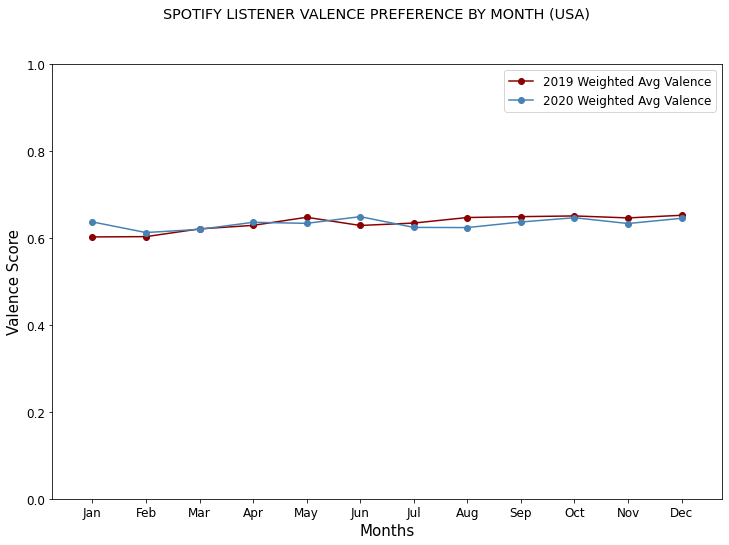

In [16]:
# Plot a comparison of 2019 2020 valence scores

# Set up lists to plot

valence_2019 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2019]

valence_2020 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2020]
valence_2020.drop('Year', inplace=True, axis=1)

fig= plt.figure(figsize=(12,8))                                      # Set up figure size
fig.suptitle('SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH (USA)')         # Set up main title

y_axis = valence_2019['Valence_Stream%']
x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',                  # Set up x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(x_axis, valence_2019['Valence_Stream%'], label="2019 Weighted Avg Valence", marker='o', color='darkred')  # Plot 2019
plt.plot(x_axis, valence_2020['Valence_Stream%'], label="2020 Weighted Avg Valence", marker='o', color='steelblue')  # Plot 2020

plt.xlabel('Months')                                                 # Set up axis titles
plt.ylabel('Valence Score')

plt.xlim(-0.75, len(x_axis)-0.25)                                    # Set up axis limits
plt.ylim(0, 1)

plt.legend()                                                         # Include the legend

plt.show()


In [17]:
# Compare valence scores with covide infection rate

covid_df = pd.read_csv("input_files/owid-covid-data.csv")                # read the covid data file

country_covid_df = covid_df.loc[covid_df['location'] == 'Mexico']   # Filter for country of your choice

country_covid_df.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
48980,MEX,North America,Mexico,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
48981,MEX,North America,Mexico,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,...,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
48982,MEX,North America,Mexico,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,...,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
48983,MEX,North America,Mexico,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,...,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
48984,MEX,North America,Mexico,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,...,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779


In [18]:
# Filter data for 2020, and add a 'month' column

country_covid__2020_df = country_covid_df[country_covid_df.date.str.contains(r'2020.*')]

country_covid__2020_df['Month'] = ''
country_covid__2020_df.head()

<ipython-input-18-9a7ab2cb5104>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_covid__2020_df['Month'] = ''


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
48980,MEX,North America,Mexico,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,
48981,MEX,North America,Mexico,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,
48982,MEX,North America,Mexico,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,
48983,MEX,North America,Mexico,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,
48984,MEX,North America,Mexico,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,


In [19]:
# Extract the month from the 'date' column and add it to the new 'month' column, for sorting later

for index, row in country_covid__2020_df.iterrows():
    month, = re.findall(f"2020-(\d\d)-", row['date'])
    country_covid__2020_df.at[index, 'Month'] = int(month)  

country_covid__2020_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
48980,MEX,North America,Mexico,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,1
48981,MEX,North America,Mexico,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,1
48982,MEX,North America,Mexico,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,1
48983,MEX,North America,Mexico,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,1
48984,MEX,North America,Mexico,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,1


In [20]:
# Create a groupby to get the sum of new cases in each month

country_covid__2020_groupby = country_covid__2020_df.groupby(['Month'], as_index=False)['new_cases'].sum()
country_covid__2020_groupby


,Month,new_cases
0,1,0.0
1,2,4.0
2,3,1211.0
3,4,18009.0
4,5,71440.0
5,6,135425.0
6,7,198548.0
7,8,174923.0
8,9,143656.0
9,10,181746.0


In [21]:
# TIP: This next section is to add missing months. In the case of New Zealand, there was no data for January
# For other countries, it might vary. Here's how I added January to the dataframe:

# No need to add january in Italy
# country_covid__2020_groupby.loc[-1] = [1, 0]             # This adds a 1 (month of January) in the first columne 
                                                         # index 0), in the last row of the dataframe. 

# country_covid__2020_groupby.index = country_covid__2020_groupby.index + 1   # shifts the index
country_covid__2020_groupby = country_covid__2020_groupby.sort_index()      # sorts by index

country_covid__2020_groupby = country_covid__2020_groupby.rename(columns={"new_cases": "New Cases"})

country_covid__2020_groupby


,Month,New Cases
0,1,0.0
1,2,4.0
2,3,1211.0
3,4,18009.0
4,5,71440.0
5,6,135425.0
6,7,198548.0
7,8,174923.0
8,9,143656.0
9,10,181746.0


In [22]:
# Merge the dataframes into one nice comparison dataframe to scatter plot

country_covid_valence_df = pd.merge(valence_2020, country_covid__2020_groupby, on="Month")

country_covid_valence_df

,Month,Valence_Stream%,New Cases
0,1,0.636675,0.0
1,2,0.612254,4.0
2,3,0.619605,1211.0
3,4,0.635788,18009.0
4,5,0.633412,71440.0
5,6,0.648761,135425.0
6,7,0.624081,198548.0
7,8,0.623695,174923.0
8,9,0.636485,143656.0
9,10,0.646364,181746.0


In [23]:
# Add a new cases per million column

country_polulation = 128932753   #TIP: This the population of New Zealand. Adjust for your country

country_covid_valence_df['New Cases Per Million'] = country_covid_valence_df['New Cases'] / country_polulation *1000000

country_covid_valence_df

,Month,Valence_Stream%,New Cases,New Cases Per Million
0,1,0.636675,0.0,0.000000
1,2,0.612254,4.0,0.031024
2,3,0.619605,1211.0,9.392493
3,4,0.635788,18009.0,139.677464
4,5,0.633412,71440.0,554.087292
5,6,0.648761,135425.0,1050.353745
6,7,0.624081,198548.0,1539.934542
7,8,0.623695,174923.0,1356.699488
8,9,0.636485,143656.0,1114.193226
9,10,0.646364,181746.0,1409.618547


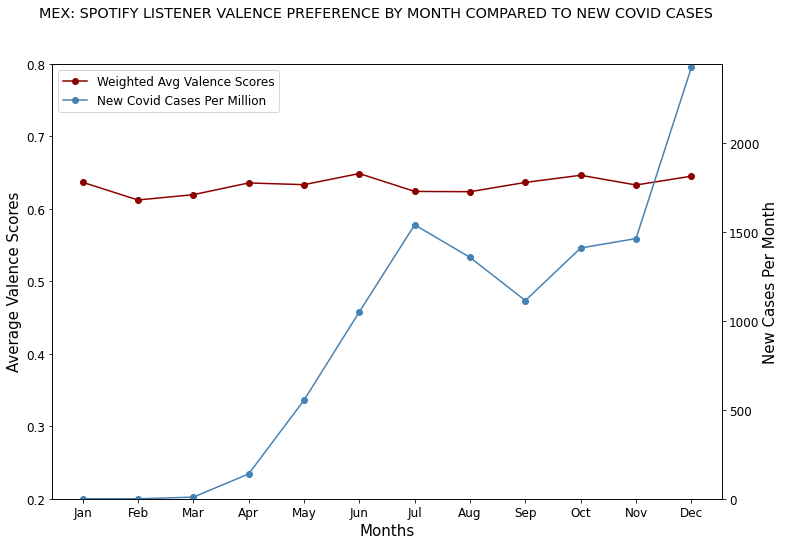

In [24]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

fig, ax1 = plt.subplots(figsize=(12,8))                   # Set up subplot figure and size
fig.suptitle('MEX: SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH COMPARED TO NEW COVID CASES')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',       # Set up shared x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax1.set_xlabel('Months')                

ax1.set_ylabel('Average Valence Scores')                  # Set up first plot 
ax1.set_ylim([.2, .8])

ax1_ydata = country_covid_valence_df['Valence_Stream%']
ax1.plot(months, ax1_ydata, label="Weighted Avg Valence Scores", marker='o', color='darkred')                       
                        
ax2 = ax1.twinx()                                         # Set up second plot 
ax2.set_ylabel('New Cases Per Month')
ax2_ydata = country_covid_valence_df['New Cases Per Million']
ax2.set_ylim([0, ax2_ydata.max()+20])
ax2.plot(months, ax2_ydata, label="New Covid Cases Per Million", marker='o', color='steelblue')


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

In [25]:
# This is a mini function that adds a qualitative label to the correlation r score in the scatter plot

def r_label(r):
    abs_r = abs(r)
    if abs_r >= .8 : return "Very Strong"
    elif abs_r >= .6 : return "Strong"
    elif abs_r >= .4: return "Moderate"
    elif abs_r >= .2: return "Low"
    else: return "Negligible"

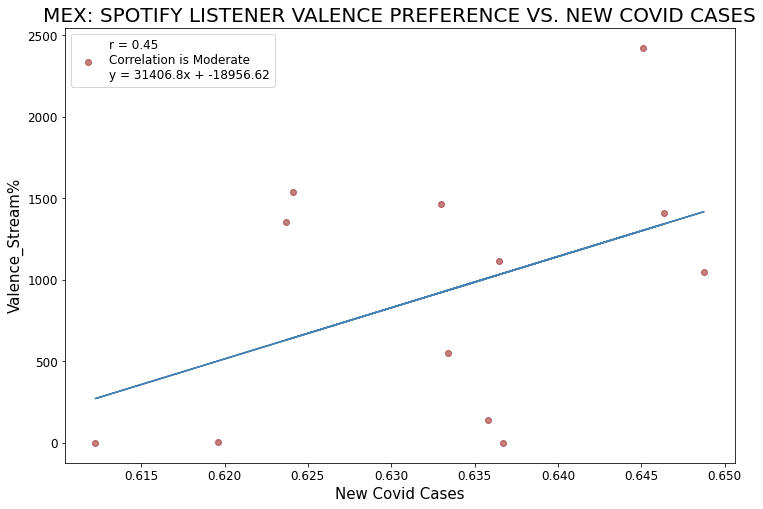

In [26]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

x_axis = country_covid_valence_df['Valence_Stream%']                                 # Set up axes
y_axis = country_covid_valence_df['New Cases Per Million']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
regress_values = x_axis * slope + intercept                                  # Calculate regression values

plt.figure(figsize=(12, 8))
plt.title('MEX: SPOTIFY LISTENER VALENCE PREFERENCE VS. NEW COVID CASES') # CHANGE TITLE TO REFLECT YOUR COUNTRY

plt.xlabel(f"New Covid Cases")                                               # Set x axis label for subplot                  
plt.ylabel(f"Valence_Stream%")                                                       # Set title for subplot

r = round(stats.pearsonr(x_axis, y_axis)[0],2)                       # Calculate correlation coefficient
rlabel = r_label(r)                                                 # Call function to create a label for the r number

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Ression formula

plt.scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
label=f"r = {r}\nCorrelation is {rlabel}\n{line_eq}" ) 

plt.plot(x_axis, regress_values, color="steelblue")                 # Plot the regression line    

plt.legend()                                                        # Add the legend
    
plt.savefig("output_files/valence_vs_newcases.png")                 # Save the png file   

plt.show()